# IMPORTS

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import re
import os
from matplotlib.patches import ConnectionPatch
from pprint import pprint
from sklearn.metrics import average_precision_score
from random import sample
import timeit

In [2]:
cv2.__version__

'3.4.2'

In [3]:
project_root = '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA'
dataset_path = project_root + '/hpatches-sequences-release/*'

# GET FOLDER + IMAGE + TRANSFORMATION NAMES

In [4]:
folders = glob.glob(project_root + '/hpatches-sequences-release/*')

In [5]:
folders[:10]

['/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_fest',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_chestnuts',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_nijmegen',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_calder',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_underground',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_talent',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_crownday',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/v_there',
 '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA/hpatches-sequences-release/i_duda',
 '/home/davidboja/PycharmProje

In [6]:
len(folders)

116

In [7]:
image_names = glob.glob(project_root + '/hpatches-sequences-release/v_london/*.ppm')
image_names = [im.split('/')[-1] for im in image_names]
image_names = sorted(image_names)

In [8]:
image_names

['1.ppm', '2.ppm', '3.ppm', '4.ppm', '5.ppm', '6.ppm']

In [9]:
transformation_names = glob.glob(project_root + '/hpatches-sequences-release/v_london/H*')
transformation_names = [tr.split('/')[-1] for tr in transformation_names]
transformation_names = sorted(transformation_names)

In [10]:
transformation_names

['H_1_2', 'H_1_3', 'H_1_4', 'H_1_5', 'H_1_6']

In [11]:
from own_implementations import *

In [12]:
class CensureClass():

    def detect(self, img, mask=None):
        keypoints = []

        censure = skimage.feature.CENSURE()
        censure.detect(img)

        for i in range(censure.keypoints.shape[0]):
              keypoints.append(cv2.KeyPoint(x=censure.keypoints[i,1],
                                            y=censure.keypoints[i,0],
                                            _size=0))

        return keypoints

In [13]:
all_detectors = {'sift':cv2.xfeatures2d.SIFT_create,
                 'surf':cv2.xfeatures2d.SURF_create,
                 'orb':cv2.ORB_create,
                 'fast':cv2.FastFeatureDetector_create,
                 'brisk':cv2.BRISK_create,
                 'harris':HarrisMataHarris,
                 'shi_tomasi':ShiTomasi,
                 'kaze':cv2.KAZE_create,
                 'akaze':cv2.AKAZE_create,
                 'mser':cv2.MSER_create,
                 'agast':cv2.AgastFeatureDetector_create,
                 'gftt':cv2.GFTTDetector_create,
                 'censure':CensureClass,
                 'asift':ASIFTClass,
                 'susan':SusanClass}

all_descriptors = {'sift':cv2.xfeatures2d.SIFT_create,
                   'surf':cv2.xfeatures2d.SURF_create,
                   'orb':cv2.ORB_create,
                   'brisk':cv2.BRISK_create,
                   'freak':cv2.xfeatures2d.FREAK_create,
                   'kaze':cv2.KAZE_create,
                   'akaze':cv2.AKAZE_create,
                   'brief':cv2.xfeatures2d.BriefDescriptorExtractor_create,
                   'root_sift':RootSIFT}


In [14]:
descriptor_distance = {'sift':cv2.NORM_L2,
                       'surf':cv2.NORM_L2,
                       'orb':cv2.NORM_HAMMING2,
                       'brisk':cv2.NORM_HAMMING2,
                       'freak':cv2.NORM_HAMMING2,
                       'kaze':cv2.NORM_L2,
                       'akaze':cv2.NORM_HAMMING2,
                       'brief':cv2.NORM_HAMMING2,
                       'root_sift':cv2.NORM_L2}

In [15]:
descriptor_distance = {'sift':cv2.NORM_L2,
                       'surf':cv2.NORM_L2,
                       'orb':cv2.NORM_HAMMING2,
                       'brisk':cv2.NORM_HAMMING2,
                       'freak':cv2.NORM_HAMMING2,
                       'kaze':cv2.NORM_L2,
                       'akaze':cv2.NORM_HAMMING2,
                       'brief':cv2.NORM_HAMMING2,
                       'root_sift':cv2.NORM_L2}

# IMPLEMENTATIONS

# CURRENTLY COMPILED KP AND DES ON DISK

In [16]:
if 'kp.npz' in os.listdir(folders[0]):
    file = np.load(folders[0] + '/kp.npz')
    print(file.files)

['harris', 'shi_tomasi', 'censure', 'kaze', 'akaze', 'sift']


In [17]:
if 'des.npz' in os.listdir(folders[0]):
    file = np.load(folders[0] + '/des.npz')
    print(file.files)

['harris_sift', 'shi_tomasi_sift', 'censure_sift', 'kaze_akaze', 'akaze_akaze', 'sift_sift']


# LOAD IMAGES + FIND KP/DES + SAVE npy OF KP/DES

In [72]:
detector_name = 'sift'
descriptor_name = 'sift'

In [73]:
def createKeypoints(detector_name, descriptor_name, dataset_path, all_at_once=False):
    '''
    For a given detector and descriptor pair, save keypoints
    and descriptors to kp.npz and des.npz in every folder for whole sequence
    '''

    sequence_images = {}
    folders = glob.glob(dataset_path)

    for folder in folders:
        folder_name = folder.split('/')[-1]
        print('Working on folder {}'.format(folder_name))

        # load sequence images in list
        sequence_images[folder_name] = glob.glob(folder + '/*.ppm')
        sequence_images[folder_name] = sorted(sequence_images[folder_name])
        sequence_images[folder_name] = [cv2.imread(im) for im in sequence_images[folder_name]]

        # convert images to gray
        images_ = [ cv2.cvtColor(im ,cv2.COLOR_RGB2GRAY) for im in sequence_images[folder_name]]

        # create detector and descriptor instances
        detector = [ all_detectors[detector_name]() for im in sequence_images[folder_name]]
        descriptor = [ all_descriptors[descriptor_name]() for im in sequence_images[folder_name]]

        kp = []
        des = []

        for id1, algorithm in enumerate(zip(detector,descriptor)):

            if not all_at_once:
                start_time = timeit.default_timer()
                kp_ = algorithm[0].detect(images_[id1],None)
                
                if len(kp_) != 0:
                    kp_, des_ = algorithm[1].compute(images_[id1], kp_)
                else:
                    des_ = np.array([])
                    
                end_time = timeit.default_timer()
                

                with open('time_measures.txt','a+') as file:
                    file.write('{},{},{}\n'.format(detector_name,
                                                   descriptor_name,
                                                   end_time-start_time))
            else:
                start_detector_and_descriptor = timeit.default_timer()
                kp, des = det.detectAndCompute(images_[id1],None)
                end_detector_and_descriptor = timeit.default_timer()

                with open('time_measures.txt','a+') as file:
                    file.write('{},{},{}\n'.format(detector_name, descriptor_name,
                        end_detector_and_descriptor-start_detector_and_descriptor))

            kp_np = np.array([(k.pt[0], k.pt[1], k.angle, k.size, k.response) for k in kp_])

            kp.append(kp_np)
            des.append(des_)

        if 'kp.npz' in os.listdir(folder):
            file = np.load(folder + '/kp.npz')
            elements = dict(file)
            elements[detector_name] = kp
            np.savez(folder + '/kp.npz', **elements)

        else:
            np.savez(folder + '/kp.npz', **{detector_name:kp})

        if 'des.npz' in os.listdir(folder):
            file = np.load(folder + '/des.npz')
            elements = dict(file)
            elements[detector_name + '_' + descriptor_name] = des
            np.savez(folder + '/des.npz', **elements)

        else:
            nm = detector_name + '_' + descriptor_name
            np.savez(folder + '/des.npz', **{nm:des})

In [74]:
createKeypoints(detector_name, descriptor_name, dataset_path, False)

Working on folder v_fest
9122
[-1]
9921
[-1]
8931
[-1]
9348
[-1]
8762
[-1]
8012
[-1]
Working on folder i_chestnuts
2024
[-1]
2644
[-1]
2689
[-1]
2518
[-1]
2018
[-1]
1739
[-1]
Working on folder i_nijmegen
6777
[-1]
5118
[-1]
6980
[-1]
2405
[-1]
5541
[-1]
5138
[-1]
Working on folder v_calder
4535
[-1]
3759
[-1]
4816
[-1]
2740
[-1]
3835
[-1]
2455
[-1]
Working on folder v_underground
4036
[-1]
3848
[-1]
2749
[-1]
2106
[-1]
1760
[-1]
1298
[-1]
Working on folder v_talent
8173
[-1]
5790
[-1]
6151
[-1]
6870
[-1]
5217
[-1]
5840
[-1]
Working on folder i_crownday
2409
[-1]
2703
[-1]
2572
[-1]
2590
[-1]
2525
[-1]
2464
[-1]
Working on folder v_there
724
[-1]
650
[-1]
2245
[-1]
2679
[-1]
2731
[-1]
2796
[-1]
Working on folder i_duda
1952
[-1]
1719
[-1]
1376
[-1]
1102
[-1]
913
[-1]
653
[-1]
Working on folder v_posters
18185
[-1]
9807
[-1]
10252
[-1]
11155
[-1]
11149
[-1]
9999
[-1]
Working on folder v_yuri
1130
[-1]
2085
[-1]
849
[-1]
852
[-1]
431
[-1]
423
[-1]
Working on folder i_objects
7493
[-1]
739

15338
[-1]
17502
[-1]
16348
[-1]
16081
[-1]
Working on folder i_pinard
951
[-1]
677
[-1]
1300
[-1]
1257
[-1]
1151
[-1]
976
[-1]
Working on folder i_partyfood
946
[-1]
848
[-1]
750
[-1]
688
[-1]
664
[-1]
602
[-1]
Working on folder i_village
1697
[-1]
1028
[-1]
1453
[-1]
1279
[-1]
1815
[-1]
1462
[-1]
Working on folder v_bird
3325
[-1]
3079
[-1]
2666
[-1]
3706
[-1]
4314
[-1]
2311
[-1]
Working on folder i_smurf
2320
[-1]
2819
[-1]
2966
[-1]
2995
[-1]
2954
[-1]
2506
[-1]
Working on folder i_ski
2283
[-1]
2131
[-1]
2075
[-1]
2076
[-1]
2007
[-1]
1793
[-1]
Working on folder v_bip
3010
[-1]
2908
[-1]
2233
[-1]
3580
[-1]
2198
[-1]
2363
[-1]
Working on folder i_tools
2799
[-1]
2214
[-1]
1455
[-1]
2180
[-1]
2249
[-1]
2316
[-1]
Working on folder i_autannes
2682
[-1]
2787
[-1]
3676
[-1]
8470
[-1]
7831
[-1]
3278
[-1]
Working on folder i_steps
1557
[-1]
975
[-1]
1513
[-1]
3317
[-1]
3479
[-1]
3772
[-1]
Working on folder v_courses
3663
[-1]
3606
[-1]
3263
[-1]
3471
[-1]
3464
[-1]
3253
[-1]
Working on fo

In [139]:
# KOD ZA PREGLEDAVANJE DIMENZIJA KP I DES
# kp_nam = 'censure'
# des_name = 'censure_sift'
# for folder in folders:
#     file = np.load(folder + '/kp.npz')
#     file = file[kp_nam]
#     file = list(file)
#     file1 = np.load(folder + '/des.npz')
#     file1 = file1[des_name]
#     file1 = list(file1)
    
#     for i in range(len(file1)):
#         print('kp:{}'.format([k.shape for k in file]))
#         print('des:{}'.format([d.shape for d in file1]))

kp:[(270, 5), (348, 5), (348, 5), (354, 5), (357, 5), (310, 5)]
des:[(270, 128), (348, 128), (348, 128), (354, 128), (357, 128), (310, 128)]
kp:[(270, 5), (348, 5), (348, 5), (354, 5), (357, 5), (310, 5)]
des:[(270, 128), (348, 128), (348, 128), (354, 128), (357, 128), (310, 128)]
kp:[(270, 5), (348, 5), (348, 5), (354, 5), (357, 5), (310, 5)]
des:[(270, 128), (348, 128), (348, 128), (354, 128), (357, 128), (310, 128)]
kp:[(270, 5), (348, 5), (348, 5), (354, 5), (357, 5), (310, 5)]
des:[(270, 128), (348, 128), (348, 128), (354, 128), (357, 128), (310, 128)]
kp:[(270, 5), (348, 5), (348, 5), (354, 5), (357, 5), (310, 5)]
des:[(270, 128), (348, 128), (348, 128), (354, 128), (357, 128), (310, 128)]
kp:[(270, 5), (348, 5), (348, 5), (354, 5), (357, 5), (310, 5)]
des:[(270, 128), (348, 128), (348, 128), (354, 128), (357, 128), (310, 128)]
kp:[(205, 5), (358, 5), (371, 5), (280, 5), (199, 5), (170, 5)]
des:[(205, 128), (358, 128), (371, 128), (280, 128), (199, 128), (170, 128)]
kp:[(205, 5),

kp:[(1023, 5), (994, 5), (879, 5), (992, 5), (861, 5), (752, 5)]
des:[(1023, 128), (994, 128), (879, 128), (992, 128), (861, 128), (752, 128)]
kp:[(1023, 5), (994, 5), (879, 5), (992, 5), (861, 5), (752, 5)]
des:[(1023, 128), (994, 128), (879, 128), (992, 128), (861, 128), (752, 128)]
kp:[(1023, 5), (994, 5), (879, 5), (992, 5), (861, 5), (752, 5)]
des:[(1023, 128), (994, 128), (879, 128), (992, 128), (861, 128), (752, 128)]
kp:[(1023, 5), (994, 5), (879, 5), (992, 5), (861, 5), (752, 5)]
des:[(1023, 128), (994, 128), (879, 128), (992, 128), (861, 128), (752, 128)]
kp:[(1023, 5), (994, 5), (879, 5), (992, 5), (861, 5), (752, 5)]
des:[(1023, 128), (994, 128), (879, 128), (992, 128), (861, 128), (752, 128)]
kp:[(1023, 5), (994, 5), (879, 5), (992, 5), (861, 5), (752, 5)]
des:[(1023, 128), (994, 128), (879, 128), (992, 128), (861, 128), (752, 128)]
kp:[(0,), (0,), (0,), (0,), (1, 5), (1, 5)]
des:[(0,), (0,), (0,), (0,), (1, 128), (1, 128)]
kp:[(0,), (0,), (0,), (0,), (1, 5), (1, 5)]
des:[

kp:[(135, 5), (844, 5), (870, 5), (431, 5), (797, 5), (167, 5)]
des:[(135, 128), (844, 128), (870, 128), (431, 128), (797, 128), (167, 128)]
kp:[(135, 5), (844, 5), (870, 5), (431, 5), (797, 5), (167, 5)]
des:[(135, 128), (844, 128), (870, 128), (431, 128), (797, 128), (167, 128)]
kp:[(135, 5), (844, 5), (870, 5), (431, 5), (797, 5), (167, 5)]
des:[(135, 128), (844, 128), (870, 128), (431, 128), (797, 128), (167, 128)]
kp:[(135, 5), (844, 5), (870, 5), (431, 5), (797, 5), (167, 5)]
des:[(135, 128), (844, 128), (870, 128), (431, 128), (797, 128), (167, 128)]
kp:[(135, 5), (844, 5), (870, 5), (431, 5), (797, 5), (167, 5)]
des:[(135, 128), (844, 128), (870, 128), (431, 128), (797, 128), (167, 128)]
kp:[(135, 5), (844, 5), (870, 5), (431, 5), (797, 5), (167, 5)]
des:[(135, 128), (844, 128), (870, 128), (431, 128), (797, 128), (167, 128)]
kp:[(60, 5), (90, 5), (117, 5), (153, 5), (192, 5), (158, 5)]
des:[(60, 128), (90, 128), (117, 128), (153, 128), (192, 128), (158, 128)]
kp:[(60, 5), (90,

kp:[(342, 5), (359, 5), (456, 5), (352, 5), (511, 5), (486, 5)]
des:[(342, 128), (359, 128), (456, 128), (352, 128), (511, 128), (486, 128)]
kp:[(342, 5), (359, 5), (456, 5), (352, 5), (511, 5), (486, 5)]
des:[(342, 128), (359, 128), (456, 128), (352, 128), (511, 128), (486, 128)]
kp:[(342, 5), (359, 5), (456, 5), (352, 5), (511, 5), (486, 5)]
des:[(342, 128), (359, 128), (456, 128), (352, 128), (511, 128), (486, 128)]
kp:[(342, 5), (359, 5), (456, 5), (352, 5), (511, 5), (486, 5)]
des:[(342, 128), (359, 128), (456, 128), (352, 128), (511, 128), (486, 128)]
kp:[(342, 5), (359, 5), (456, 5), (352, 5), (511, 5), (486, 5)]
des:[(342, 128), (359, 128), (456, 128), (352, 128), (511, 128), (486, 128)]
kp:[(342, 5), (359, 5), (456, 5), (352, 5), (511, 5), (486, 5)]
des:[(342, 128), (359, 128), (456, 128), (352, 128), (511, 128), (486, 128)]
kp:[(108, 5), (116, 5), (325, 5), (254, 5), (149, 5), (82, 5)]
des:[(108, 128), (116, 128), (325, 128), (254, 128), (149, 128), (82, 128)]
kp:[(108, 5), (

kp:[(132, 5), (101, 5), (82, 5), (47, 5), (40, 5), (80, 5)]
des:[(132, 128), (101, 128), (82, 128), (47, 128), (40, 128), (80, 128)]
kp:[(132, 5), (101, 5), (82, 5), (47, 5), (40, 5), (80, 5)]
des:[(132, 128), (101, 128), (82, 128), (47, 128), (40, 128), (80, 128)]
kp:[(132, 5), (101, 5), (82, 5), (47, 5), (40, 5), (80, 5)]
des:[(132, 128), (101, 128), (82, 128), (47, 128), (40, 128), (80, 128)]
kp:[(132, 5), (101, 5), (82, 5), (47, 5), (40, 5), (80, 5)]
des:[(132, 128), (101, 128), (82, 128), (47, 128), (40, 128), (80, 128)]
kp:[(132, 5), (101, 5), (82, 5), (47, 5), (40, 5), (80, 5)]
des:[(132, 128), (101, 128), (82, 128), (47, 128), (40, 128), (80, 128)]
kp:[(132, 5), (101, 5), (82, 5), (47, 5), (40, 5), (80, 5)]
des:[(132, 128), (101, 128), (82, 128), (47, 128), (40, 128), (80, 128)]
kp:[(35, 5), (77, 5), (78, 5), (42, 5), (39, 5), (24, 5)]
des:[(35, 128), (77, 128), (78, 128), (42, 128), (39, 128), (24, 128)]
kp:[(35, 5), (77, 5), (78, 5), (42, 5), (39, 5), (24, 5)]
des:[(35, 128),

kp:[(280, 5), (312, 5), (319, 5), (241, 5), (291, 5), (245, 5)]
des:[(280, 128), (312, 128), (319, 128), (241, 128), (291, 128), (245, 128)]
kp:[(280, 5), (312, 5), (319, 5), (241, 5), (291, 5), (245, 5)]
des:[(280, 128), (312, 128), (319, 128), (241, 128), (291, 128), (245, 128)]
kp:[(280, 5), (312, 5), (319, 5), (241, 5), (291, 5), (245, 5)]
des:[(280, 128), (312, 128), (319, 128), (241, 128), (291, 128), (245, 128)]
kp:[(280, 5), (312, 5), (319, 5), (241, 5), (291, 5), (245, 5)]
des:[(280, 128), (312, 128), (319, 128), (241, 128), (291, 128), (245, 128)]
kp:[(280, 5), (312, 5), (319, 5), (241, 5), (291, 5), (245, 5)]
des:[(280, 128), (312, 128), (319, 128), (241, 128), (291, 128), (245, 128)]
kp:[(280, 5), (312, 5), (319, 5), (241, 5), (291, 5), (245, 5)]
des:[(280, 128), (312, 128), (319, 128), (241, 128), (291, 128), (245, 128)]
kp:[(413, 5), (211, 5), (144, 5), (262, 5), (247, 5), (144, 5)]
des:[(413, 128), (211, 128), (144, 128), (262, 128), (247, 128), (144, 128)]
kp:[(413, 5),

kp:[(1850, 5), (1874, 5), (1957, 5), (1576, 5), (1325, 5), (1472, 5)]
des:[(1850, 128), (1874, 128), (1957, 128), (1576, 128), (1325, 128), (1472, 128)]
kp:[(1850, 5), (1874, 5), (1957, 5), (1576, 5), (1325, 5), (1472, 5)]
des:[(1850, 128), (1874, 128), (1957, 128), (1576, 128), (1325, 128), (1472, 128)]
kp:[(1850, 5), (1874, 5), (1957, 5), (1576, 5), (1325, 5), (1472, 5)]
des:[(1850, 128), (1874, 128), (1957, 128), (1576, 128), (1325, 128), (1472, 128)]
kp:[(1850, 5), (1874, 5), (1957, 5), (1576, 5), (1325, 5), (1472, 5)]
des:[(1850, 128), (1874, 128), (1957, 128), (1576, 128), (1325, 128), (1472, 128)]
kp:[(1850, 5), (1874, 5), (1957, 5), (1576, 5), (1325, 5), (1472, 5)]
des:[(1850, 128), (1874, 128), (1957, 128), (1576, 128), (1325, 128), (1472, 128)]
kp:[(1850, 5), (1874, 5), (1957, 5), (1576, 5), (1325, 5), (1472, 5)]
des:[(1850, 128), (1874, 128), (1957, 128), (1576, 128), (1325, 128), (1472, 128)]
kp:[(334, 5), (579, 5), (748, 5), (824, 5), (867, 5), (884, 5)]
des:[(334, 128), (

kp:[(121, 5), (89, 5), (102, 5), (85, 5), (54, 5), (40, 5)]
des:[(121, 128), (89, 128), (102, 128), (85, 128), (54, 128), (40, 128)]
kp:[(121, 5), (89, 5), (102, 5), (85, 5), (54, 5), (40, 5)]
des:[(121, 128), (89, 128), (102, 128), (85, 128), (54, 128), (40, 128)]
kp:[(121, 5), (89, 5), (102, 5), (85, 5), (54, 5), (40, 5)]
des:[(121, 128), (89, 128), (102, 128), (85, 128), (54, 128), (40, 128)]
kp:[(121, 5), (89, 5), (102, 5), (85, 5), (54, 5), (40, 5)]
des:[(121, 128), (89, 128), (102, 128), (85, 128), (54, 128), (40, 128)]
kp:[(121, 5), (89, 5), (102, 5), (85, 5), (54, 5), (40, 5)]
des:[(121, 128), (89, 128), (102, 128), (85, 128), (54, 128), (40, 128)]
kp:[(121, 5), (89, 5), (102, 5), (85, 5), (54, 5), (40, 5)]
des:[(121, 128), (89, 128), (102, 128), (85, 128), (54, 128), (40, 128)]
kp:[(18, 5), (23, 5), (63, 5), (38, 5), (34, 5), (53, 5)]
des:[(18, 128), (23, 128), (63, 128), (38, 128), (34, 128), (53, 128)]
kp:[(18, 5), (23, 5), (63, 5), (38, 5), (34, 5), (53, 5)]
des:[(18, 128),

kp:[(243, 5), (330, 5), (283, 5), (351, 5), (193, 5), (257, 5)]
des:[(243, 128), (330, 128), (283, 128), (351, 128), (193, 128), (257, 128)]
kp:[(243, 5), (330, 5), (283, 5), (351, 5), (193, 5), (257, 5)]
des:[(243, 128), (330, 128), (283, 128), (351, 128), (193, 128), (257, 128)]
kp:[(243, 5), (330, 5), (283, 5), (351, 5), (193, 5), (257, 5)]
des:[(243, 128), (330, 128), (283, 128), (351, 128), (193, 128), (257, 128)]
kp:[(243, 5), (330, 5), (283, 5), (351, 5), (193, 5), (257, 5)]
des:[(243, 128), (330, 128), (283, 128), (351, 128), (193, 128), (257, 128)]
kp:[(243, 5), (330, 5), (283, 5), (351, 5), (193, 5), (257, 5)]
des:[(243, 128), (330, 128), (283, 128), (351, 128), (193, 128), (257, 128)]
kp:[(243, 5), (330, 5), (283, 5), (351, 5), (193, 5), (257, 5)]
des:[(243, 128), (330, 128), (283, 128), (351, 128), (193, 128), (257, 128)]
kp:[(791, 5), (504, 5), (435, 5), (427, 5), (209, 5), (638, 5)]
des:[(791, 128), (504, 128), (435, 128), (427, 128), (209, 128), (638, 128)]
kp:[(791, 5),

# LOAD KP/DES npy AND REMOVE UNCOMMON POINTS

In [75]:
detector_name = 'sift'
descriptor_name = 'sift'

In [76]:
def getTransformations(dataset_path):
    transformations = {}
    folders = glob.glob(dataset_path)

    def load_transform(tr):
        with open(tr) as file:
            s = file.read()
            nrs = re.split('\n| ',s)[:-1]
            nrs = [nr for nr in nrs if nr != '']
            return np.array(nrs).reshape(3,3).astype(np.float)

    for folder in folders:
        folder_name = folder.split('/')[-1]
        transformations[folder_name] = glob.glob(folder + '/H*')
        transformations[folder_name] = sorted(transformations[folder_name])
        transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

    return transformations

In [77]:
def removeUncommonPoints(detector_name, descriptor_name, dataset_path):
    '''
    Remove keypoints from ref image that do not appear on sequence images
    when imaged with homography H.
    This function expects that keypoints already exist in kp.npz and des.npz
    for given detector and descriptor names.
    '''
    transformations = getTransformations(dataset_path)
    folders = glob.glob(dataset_path)


    for folder in folders:
        folder_name = folder.split('/')[-1]
        print('#########################################')
        print('Working on folder {}'.format(folder_name))

        kp_file = np.load(folder + '/kp.npz')
        kp = kp_file[detector_name]
        kp = list(kp)

        des_file = np.load(folder + '/des.npz')
        nm = detector_name + '_' + descriptor_name
        des = des_file[nm]
        des = list(des)

        indexes_to_remove = []

        # remove keypoints from ref image that do not appear on sequence images
        remove = set()
        kp_ = kp[0].copy()

        # iterate over homographies H and image points onto sequence image
        for id2, tr in enumerate(transformations[folder_name]):
            # image points
            if kp_.shape[0] == 0:
                with open('missing_kp_on_ref','a+') as fl:
                    fl.write('{}: algo with no kp on 1.ppm for folder {} and image {}.'.format(detector_name,
                                                                                               folder_name,
                                                                                               id2+2))
                print('THERE ARE NO KEYPOINTS ON IMAGE 1.ppm IN FOLDER {}'.format(folder_name))
                continue
            points = np.c_[ kp_[:,[0,1]] , np.ones(kp_.shape[0])]
            imaged_points = np.dot(tr, points.T)
            imaged_points_normal = imaged_points/imaged_points[2,:]

            # get bounds of image on which we are projecting
            image_size = cv2.imread(folder + '/' + str(id2+2) + '.ppm' )
            image_size = image_size.shape

            # get indexes that are out of bounds on the sequence image
            x_indexes_out_of_bounds = np.where((imaged_points_normal[0,:] < 0) |
                                               (image_size[1] < imaged_points_normal[0,:]))[0]


            y_indexes_out_of_bounds = np.where((imaged_points_normal[1,:] < 0) |
                                               (image_size[0] < imaged_points_normal[1,:]))[0]

            # add the indexes to set
            remove = remove.union(x_indexes_out_of_bounds)
            remove = remove.union(y_indexes_out_of_bounds)

        # create a list from the set
        indexes_to_remove = list(remove)

        # delete the indexes
        print('Removing {} keypoints from image {}/1.ppm'.format(len(indexes_to_remove),folder_name))
        print('old size: {}'.format(kp[0].shape))
        kp[0] = np.delete(kp[0], indexes_to_remove, 0)
        print('new size: {}'.format(kp[0].shape))

        des[0] = np.delete(des[0], indexes_to_remove, 0)

        # save the new keypoints to disk
        elements = dict(kp_file)
        elements[detector_name] = kp
        np.savez(folder + '/kp.npz', **elements)

        elements = dict(des_file)
        elements[nm] = des
        np.savez(folder + '/des.npz', **elements)

In [78]:
removeUncommonPoints(detector_name, descriptor_name, dataset_path)

#########################################
Working on folder v_fest
Removing 4520 keypoints from image v_fest/1.ppm
old size: (9122, 5)
new size: (4602, 5)
#########################################
Working on folder i_chestnuts
Removing 0 keypoints from image i_chestnuts/1.ppm
old size: (2024, 5)
new size: (2024, 5)
#########################################
Working on folder i_nijmegen
Removing 0 keypoints from image i_nijmegen/1.ppm
old size: (6777, 5)
new size: (6777, 5)
#########################################
Working on folder v_calder
Removing 298 keypoints from image v_calder/1.ppm
old size: (4535, 5)
new size: (4237, 5)
#########################################
Working on folder v_underground
Removing 1701 keypoints from image v_underground/1.ppm
old size: (4036, 5)
new size: (2335, 5)
#########################################
Working on folder v_talent
Removing 249 keypoints from image v_talent/1.ppm
old size: (8173, 5)
new size: (7924, 5)
######################################

#########################################
Working on folder i_toy
Removing 0 keypoints from image i_toy/1.ppm
old size: (978, 5)
new size: (978, 5)
#########################################
Working on folder v_apprentices
Removing 918 keypoints from image v_apprentices/1.ppm
old size: (10235, 5)
new size: (9317, 5)
#########################################
Working on folder v_home
Removing 2118 keypoints from image v_home/1.ppm
old size: (7071, 5)
new size: (4953, 5)
#########################################
Working on folder i_lionday
Removing 0 keypoints from image i_lionday/1.ppm
old size: (1402, 5)
new size: (1402, 5)
#########################################
Working on folder v_bark
Removing 509 keypoints from image v_bark/1.ppm
old size: (3734, 5)
new size: (3225, 5)
#########################################
Working on folder v_samples
Removing 338 keypoints from image v_samples/1.ppm
old size: (7963, 5)
new size: (7625, 5)
#########################################
Working on fol

#########################################
Working on folder v_courses
Removing 234 keypoints from image v_courses/1.ppm
old size: (3663, 5)
new size: (3429, 5)
#########################################
Working on folder v_colors
Removing 86 keypoints from image v_colors/1.ppm
old size: (302, 5)
new size: (216, 5)
#########################################
Working on folder i_ktirio
Removing 0 keypoints from image i_ktirio/1.ppm
old size: (1807, 5)
new size: (1807, 5)
#########################################
Working on folder v_wounded
Removing 1526 keypoints from image v_wounded/1.ppm
old size: (4281, 5)
new size: (2755, 5)
#########################################
Working on folder v_tabletop
Removing 3772 keypoints from image v_tabletop/1.ppm
old size: (9958, 5)
new size: (6186, 5)
#########################################
Working on folder v_birdwoman
Removing 1784 keypoints from image v_birdwoman/1.ppm
old size: (11756, 5)
new size: (9972, 5)
#######################################

# VISUALIZE KEYPOINTS FOR GIVEN FOLDER AND ALGORITHM

In [79]:
folder = 'v_london'
detector_name = 'sift'

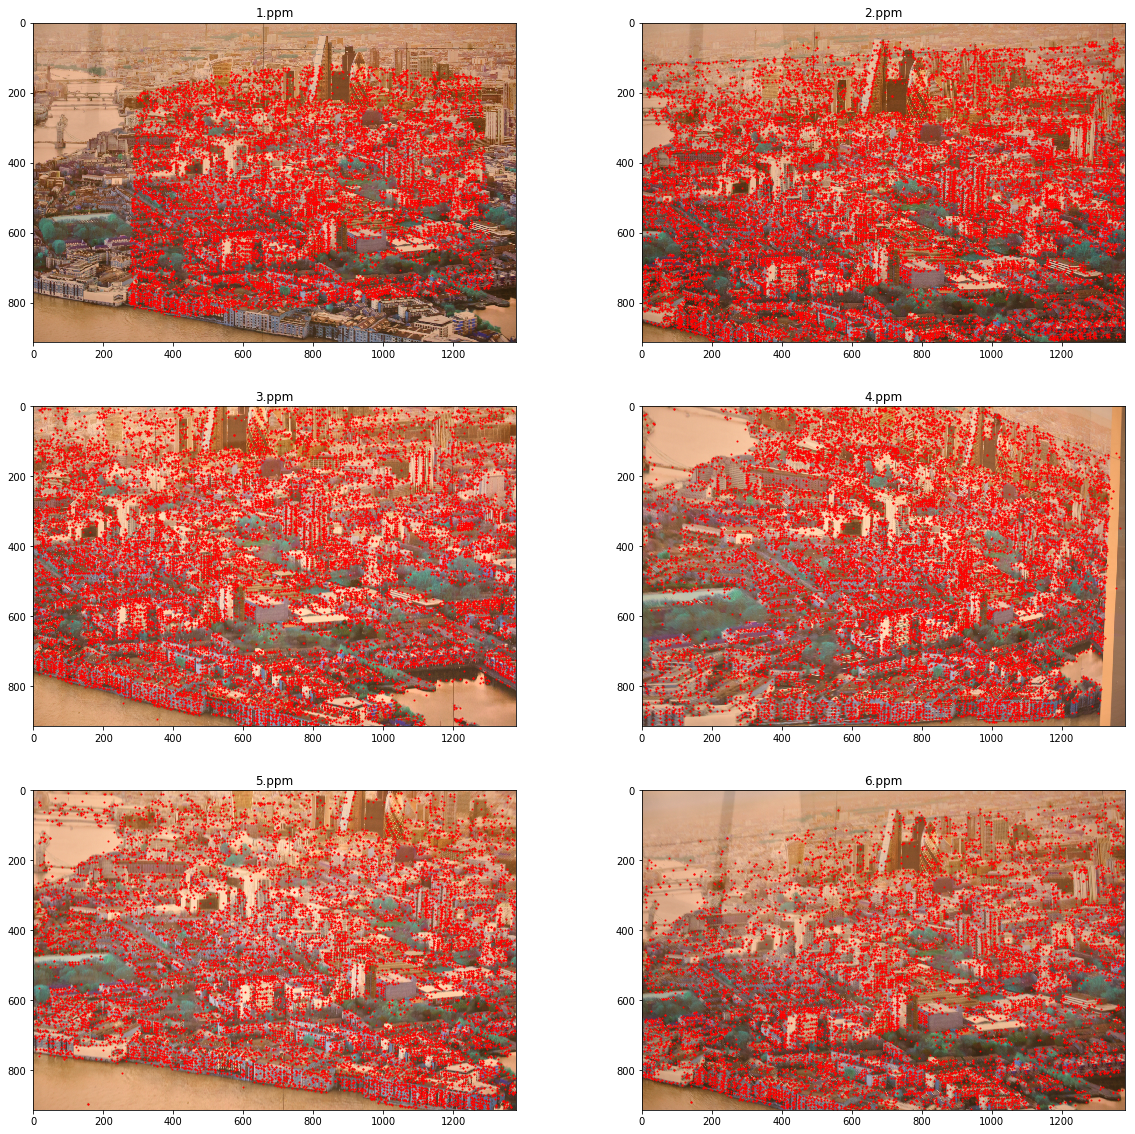

In [80]:
sequence_images = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/*.ppm')
sequence_images = sorted(sequence_images)
sequence_images = [cv2.imread(im) for im in sequence_images]

kp = np.load(project_root + '/hpatches-sequences-release/' + folder + '/kp.npz')
kp = kp[detector_name]
kp = list(kp)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
for id1, axx in enumerate(ax.ravel()):
    
    #gray = cv2.cvtColor(sequence_images[id1] ,cv2.COLOR_RGB2GRAY)
#     gray_with_kp = cv2.drawKeypoints(gray, 
#                                      kp[id1], 
#                                      cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    
#     axx.imshow(gray_with_kp)
    
    if kp[id1].shape[0] !=0:
        axx.imshow(sequence_images[id1])
        axx.scatter(kp[id1][:,0],kp[id1][:,1], s=1, color='red')
    else:
        axx.imshow(sequence_images[id1])
    
#     for i in range(kp[id1].shape[0]):
#         sequence_images[id1][int(kp[id1][i,0]),int(kp[id1][i,1])] = [255,0,0]
#     axx.imshow(sequence_images[id1])
    
    axx.set_title('{}'.format(image_names[id1]))
plt.show()

# DRAW TOP TEN MATCHES FOR GIVEN FOLDER AND ALGORITHM

In [206]:
folder = 'v_london'
detector_name = 'shi_tomasi'
descriptor_name = 'sift'

### LOAD  IMG/KP/DES

In [207]:
sequence_images = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/*.ppm')
sequence_images = sorted(sequence_images)
sequence_images = [cv2.imread(im) for im in sequence_images]

# kp_names = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/kp_' + detector_name + '*')
# kp_names = sorted(kp_names)
# kp = [np.load(k) for k in kp_names]

# des_names = glob.glob(project_root + '/hpatches-sequences-release/' + folder + '/des_' + descriptor_name + '*')
# des_names = sorted(des_names)
# des = [np.load(d) for d in des_names]

kp = np.load(project_root + '/hpatches-sequences-release/' + folder + '/kp.npz')
kp = kp[detector_name]

des = np.load(project_root + '/hpatches-sequences-release/' + folder + '/des.npz')
nm = detector_name + '_' + descriptor_name
des = des[nm]

In [208]:
print(len(sequence_images))
print(len(kp))
print(len(des))

6
6
6


### COMPUTE MATCHES

In [209]:
matches_with_ref = []

In [210]:
for dess in des[1:]:
    bf = cv2.BFMatcher(cv2.NORM_L2)#, crossCheck=True)
    matches = bf.match(des[0], dess)
    matches_with_ref.append(sorted(matches, key = lambda x:x.distance))

In [211]:
len(matches_with_ref)

5

### VISUALIZE TOP TEN MATCHES FOR SEQUENCE

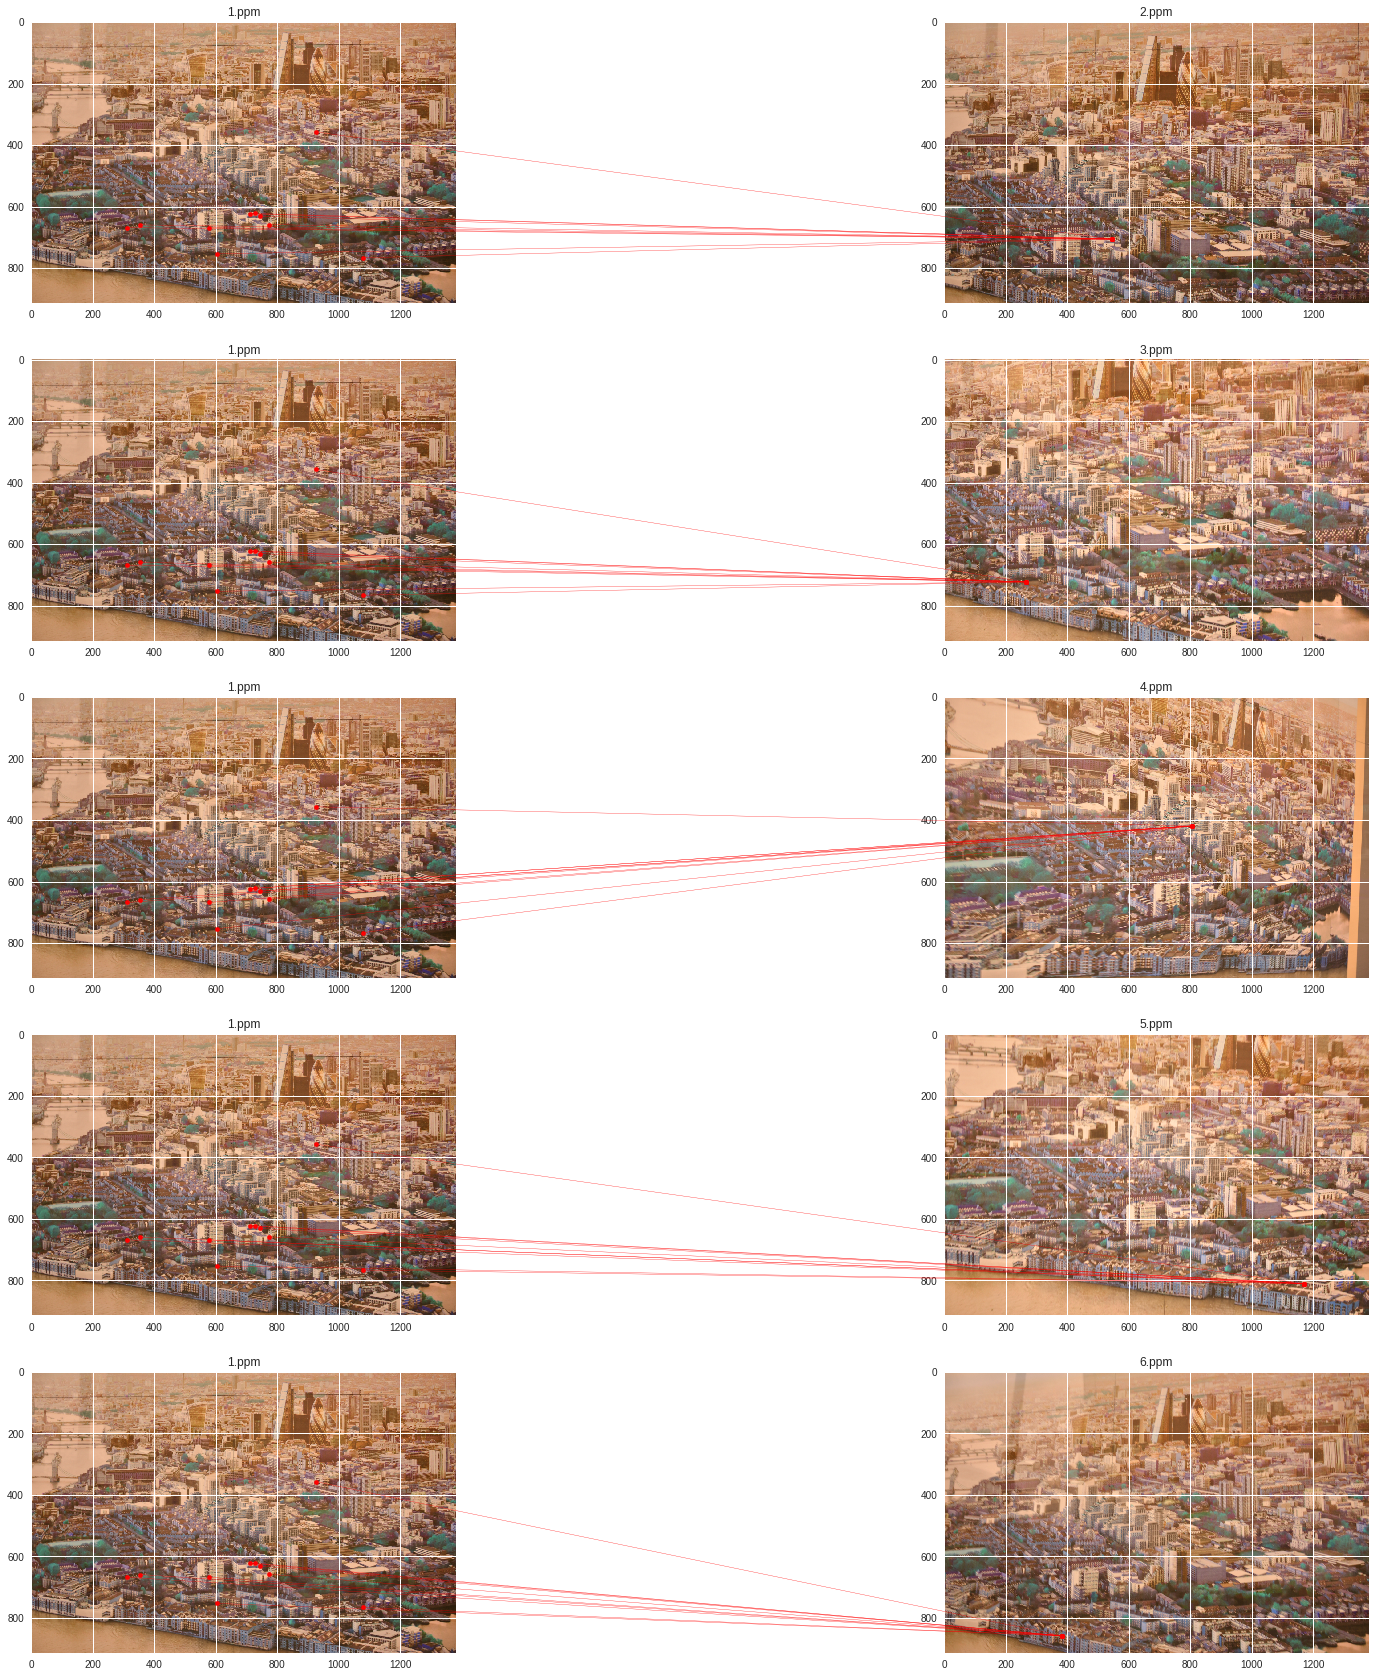

In [212]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(30,30))
for i, axx in enumerate(ax.ravel()):
    if (i % 2) == 1:
        continue
        
    points_on_first_img = []
    points_on_second_img = []
    
    axx.imshow(sequence_images[0])
    axx.set_title('{}'.format(image_names[0]))
    ax.ravel()[i+1].imshow(sequence_images[int(i/2)+1])
    ax.ravel()[i+1].set_title('{}'.format(image_names[int(i/2)+1]))
    
    for m in matches_with_ref[int(i/2)][:10]:
        points_on_first_img.append(kp[0][m.queryIdx,[0,1]])
        points_on_second_img.append(kp[int(i/2)+1][m.trainIdx,[0,1]])
        
    axx.scatter([i[0] for i in points_on_first_img],
                [i[1] for i in points_on_first_img],
                s=20, 
                c='red')
    
    ax.ravel()[i+1].scatter([i[0] for i in points_on_second_img],
                            [i[1] for i in points_on_second_img],
                            s=20, 
                            c='red')
    
    for j in range(len(points_on_first_img)):
        con = ConnectionPatch(xyA=(points_on_second_img[j][0],points_on_second_img[j][1]), 
                              xyB=(points_on_first_img[j][0],points_on_first_img[j][1]),
                              coordsA="data", coordsB="data",
                              axesA=ax.ravel()[i+1], axesB=axx, color="red")
        
        ax.ravel()[i+1].add_artist(con)
    

plt.show()

# EVALUATION

# TASK 1: PATCH VERIFICATION

In [81]:
n = 100

In [82]:
detector_name = 'sift'
descriptor_name = 'sift'

In [83]:
def load_transform(tr):
    with open(tr) as file:
        s = file.read()
        nrs = re.split('\n| ',s)[:-1]
        nrs = [nr for nr in nrs if nr != '']
        return np.array(nrs).reshape(3,3).astype(np.float)

In [64]:
# c = np.array([[1,2,3],[4,5,6],[7,8,9],[11,12,13]])
# a = np.array([[1,2,3],[4,5,6],[7,8,9]])
# b = np.array([[11,5,4],[5,8,9],[1,3,7]])

In [84]:
def getTransformations(dataset_path):
    transformations = {}
    folders = glob.glob(dataset_path)

    def load_transform(tr):
        with open(tr) as file:
            s = file.read()
            nrs = re.split('\n| ',s)[:-1]
            nrs = [nr for nr in nrs if nr != '']
            return np.array(nrs).reshape(3,3).astype(np.float)

    for folder in folders:
        folder_name = folder.split('/')[-1]
        transformations[folder_name] = glob.glob(folder + '/H*')
        transformations[folder_name] = sorted(transformations[folder_name])
        transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

    return transformations

In [26]:
from utils import read_keypoints

In [86]:
def read_next_keypoints(detector_name, descriptor_name, folder_id, m=100):
    
    kp_all = []
    des_all = []
    
    random_images = sample(range(len(folders)), m)
    
    for ind in random_images:
        seq = (folder_id+ind) % len(folders)
        image_nr = ind%6
            
        kp = np.load(folders[seq] + '/kp.npz')
        kp = list(kp[detector_name])
        kp = kp[image_nr]
        kp_all.append(kp)
        
        des = np.load(folders[seq]+'/des.npz')
        nm = detector_name + '_' + descriptor_name
        des = list(des[nm])
        des = des[image_nr]
        des_all.append(des)
        
    return kp_all, des_all

In [87]:
def patchVerification(detector_name, descriptor_name, n, dataset_path, nr_of_iterations=1):
    '''
    Task 1: Patch Verification
    + save results to patchVerification.txt

    Return: list_of_APs - list of APs per iteration
            mAP         - average AP per number of iterations
    '''

    transformations = getTransformations(dataset_path)
    folders = glob.glob(dataset_path)
    list_of_APs = []
    list_of_APs_i = []
    list_of_APs_v = []

    for i in range(nr_of_iterations):
        y = []
        y_i = []
        y_v = []
        s = []
        s_i = []
        s_v = []

        for folder_id, folder in enumerate(folders):

            folder_name = folder.split('/')[-1]

            # get keypoints and descriptors from sequence in folder
            kp, des = read_keypoints(folder, detector_name, descriptor_name)

            # get keypoints from next folder
            kp_next, des_next = read_next_keypoints(detector_name, descriptor_name, folder_id, 100)
#             next_folder = folders[(folder_id + 1) % len(folders)]
#             kp_next, des_next = read_keypoints(next_folder,
#                                                detector_name,
#                                                descriptor_name)

            # printout
            print('pV: Working on folder {}'.format(folder_name))

            # check if ref image has no keypoints and skip evaluation of sequence
            if 0 == kp[0].shape[0]:
                print('Folder {} has 0 keypoints for ref image'.format(folder))
                print('SKIPPING THIS FOLDER')
                continue

            # random keypoints from ref image
            nr_of_indexes = min(n, kp[0].shape[0])
            random_keypoint_indexes = sample(range(kp[0].shape[0]), nr_of_indexes)

            # choose ref image
            x_kp = kp[0][random_keypoint_indexes,:]
            x_des = des[0][random_keypoint_indexes,:]


            # iterate over descriptors of sequence images
            for id1, dess in enumerate(des[1:]):

                # match ref image and sequence image
                bf = cv2.BFMatcher(descriptor_distance[descriptor_name])
                matches = bf.match(x_des,
                                   dess)

                # get the indexes from the matching procedure above
                x_idx = [random_keypoint_indexes[m.queryIdx] for m in matches]
                x_crtano_idx = [m.trainIdx for m in matches]

                # measure s with which we rank the AP
                s += [m.distance for m in matches]
                if 'i_' in folder_name:
                    s_i += [m.distance for m in matches]
                else:
                    s_v += [m.distance for m in matches]

                # image every keypoint from ref image to sequence image
                # we get Hx points as columns, 3xn matrix (third row are 1 -
                # homogen coordinates)
                tr = transformations[folder_name][id1]
                points = np.c_[ kp[0][x_idx,:][:,[0,1]] , np.ones(len(x_idx))]
                imaged_points = np.dot(tr, points.T)
                imaged_points_normal = imaged_points/imaged_points[2,:]

                # compute distance from Hx and x' (matching keypoints from sequence image)
                dist = kp[id1+1][x_crtano_idx,:][:,[0,1]].T - imaged_points_normal[[0,1],:]
                distances = np.sqrt(np.sum((dist)**2,axis=0))

                # find if x' is the closest keypoint to Hx and assign y
                for i in range(imaged_points_normal.shape[1]):
                    # dist_ is the distance from point Hx and every keypoint of image id1+1
                    diff = kp[id1+1][:,[0,1]].T - imaged_points_normal[[0,1],i].reshape(2,1)
                    dist_ = np.sqrt(np.sum((diff)**2,axis=0))
                    if (dist_ < distances[i]).any():
                        y.append(-1)
                        if 'i_' in folder_name:
                            y_i.append(-1)
                        else:
                            y_v.append(-1)
                    else:
                        y.append(1)
                        if 'i_' in folder_name:
                            y_i.append(1)
                        else:
                            y_v.append(1)

            # iterate over descriptors of non-sequence images
            for id2, dess in enumerate(des_next[1:]):
                bf = cv2.BFMatcher(descriptor_distance[descriptor_name])
                matches = bf.match(x_des,
                                   dess)

                s += [m.distance for m in matches]
                y += [-1 for m in matches]

                if 'i_' in folder_name:
                    s_i += [m.distance for m in matches]
                    y_i += [-1 for m in matches]
                else:
                    s_v += [m.distance for m in matches]
                    y_v += [-1 for m in matches]



        s2 = [-s_ for s_ in s]
        AP = average_precision_score(y,s2)
        list_of_APs.append(AP)

        s_i = [-s_ for s_ in s_i]
        AP_i = average_precision_score(y_i,s_i)
        list_of_APs_i.append(AP_i)

        s_v = [-s_ for s_ in s_v]
        AP_v = average_precision_score(y_v,s_v)
        list_of_APs_v.append(AP_v)


    return list_of_APs, list_of_APs_i, list_of_APs_v

In [88]:
project_root = '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA'
dataset_path = project_root + '/hpatches-sequences-release/*'

In [89]:
list_of_APs, list_of_APs_i, list_of_APs_v = patchVerification(detector_name, descriptor_name, n, dataset_path, 1)

pV: Working on folder v_fest
pV: Working on folder i_chestnuts
pV: Working on folder i_nijmegen
pV: Working on folder v_calder
pV: Working on folder v_underground
pV: Working on folder v_talent
pV: Working on folder i_crownday
pV: Working on folder v_there
pV: Working on folder i_duda
pV: Working on folder v_posters
pV: Working on folder v_yuri
pV: Working on folder i_objects
pV: Working on folder i_nuts
pV: Working on folder v_blueprint
pV: Working on folder i_pencils
pV: Working on folder i_fruits
pV: Working on folder i_porta
pV: Working on folder v_london
pV: Working on folder v_beyus
pV: Working on folder v_weapons
pV: Working on folder v_graffiti
pV: Working on folder v_azzola
pV: Working on folder v_woman
pV: Working on folder i_leuven
pV: Working on folder v_vitro
pV: Working on folder i_miniature
pV: Working on folder v_bricks
pV: Working on folder v_gardens
pV: Working on folder i_londonbridge
pV: Working on folder v_dirtywall
pV: Working on folder i_dc
pV: Working on folder 

In [90]:
list_of_APs, list_of_APs_i, list_of_APs_v

([0.11706855856813195], [0.12934203443084147], [0.10692308523594889])

In [222]:
print(y.count(1))
print(y.count(-1))

91
115909


Trebalo bi biti n * 10 * broj_foldera <br> (AKO UZIMA n TOCAKA)

In [223]:
n*10*len(folders) == len(y)

True

Potencijalnih matcheva je n * 5 * broj_foldera

In [224]:
n * 5 * len(folders)

58000

In [225]:
AP = average_precision_score(y,s2)
print(AP)

0.0007844827586206897


In [226]:
print('| x | {} | {} | {} | {} | {} | {} | {} |'.format(detector_name,
                                                        descriptor_name,
                                                        AP,
                                                        n,
                                                        y.count(1),
                                                        y.count(-1),
                                                        n*5*len(folders)))

| x | shi_tomasi | sift | 0.0007844827586206897 | 100 | 91 | 115909 | 58000 |


| id | det | des | AP | max n | 1 | -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | sift | sift | 0.586862720350904 | 100 | 14914 | 101086 | 58000 |
| 2 | sift | sift | 0.593464318477201 | 100 | 15239 | 100761 | 58000 |
| 3 | sift | sift | 0.6065553783395058 | 100 | 15187 | 100813 | 58000 |
| 4 | sift | sift | 0.5908968401464723 | 100 | 15141 | 100859 | 58000 |
| 5 | sift | sift | 0.6003174809347416 | 100 | 15107 | 100893 | 58000 |
| 6 | surf | surf | 0.3899221777180763 | 100 | 13210 | 102790 | 58000 |
| 7 | ORB | ORB | 0.4301131784419977 | 50 | 3708 | 53212 | 29000 |
| 8 | fast | sift | 0.6984606609463924 | 50 | 11662 | 46338 | 29000 |
| 9 | brisk | brisk | 0.5529112571630087 | 100 | 10430 | 105570 | 58000 |
| 10 | brisk | freak | 0.3873563875490459 | 100 | 10065 | 105695 | 58000 |
| 11 | harris | sift | 0.000854332067656196 | 100 | 99 | 115781 | 58000 |
| 12 | shi_tomasi | sift | 0.0007844827586206897 | 100 | 91 | 115909 | 58000 |





n je max tocaka koji uzimamo jer potencijalno nema toliko tocaka, pa uzmemo manje

| id | det | des | 5_mAP | n | mean 1 | mean -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | sift | sift | 0.5956193476497649 | 100 | 15117.6 | 100882.4 | 58000 |

# TASK 2: IMAGE MATCHING

In [165]:
n = 100

In [166]:
detector_name = 'fast'
descriptor_name = 'sift'

In [167]:
def getTransformations(dataset_path):
    transformations = {}
    folders = glob.glob(dataset_path)

    def load_transform(tr):
        with open(tr) as file:
            s = file.read()
            nrs = re.split('\n| ',s)[:-1]
            nrs = [nr for nr in nrs if nr != '']
            return np.array(nrs).reshape(3,3).astype(np.float)

    for folder in folders:
        folder_name = folder.split('/')[-1]
        transformations[folder_name] = glob.glob(folder + '/H*')
        transformations[folder_name] = sorted(transformations[folder_name])
        transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

    return transformations

In [168]:
def imageMatching(detector_name, descriptor_name, n, dataset_path, nr_of_iterations=1):
    '''
    Task 2: Image Matching.
    + save results to imageMatching.txt

    Return: list_of_APs: list of average precision for every iteration
            mAP: mean of list_of_APs
    '''

    transformations = getTransformations(dataset_path)
    folders = glob.glob(dataset_path)
    list_of_mAPs = []
    list_of_mAPs_i = []
    list_of_mAPs_v = []

    for i in range(nr_of_iterations):

        list_of_APs = []
        list_of_APs_i = []
        list_of_APs_v = []

        for folder in folders:

            folder_name = folder.split('/')[-1]
            print('Working on folder {}'.format(folder_name,))

            # get keypoints from sequence
            kp = np.load(folder + '/kp.npz')
            kp = kp[detector_name]
            kp = list(kp)

            # get descriptors from sequence
            des = np.load(folder + '/des.npz')
            nm = detector_name + '_' + descriptor_name
            des = des[nm]
            des = list(des)


            # if an image has no keypoints skip that evaluating sequence
            if 0 == kp[0].shape[0]:
                print('Folder {} has 0 keypoints for ref image'.format(folder))
                print('SKIPPING THIS FOLDER')
                continue

            # random keypoints from ref image
            nr_of_indexes = min(n,kp[0].shape[0])
            random_keypoint_indexes = sample(range(kp[0].shape[0]), nr_of_indexes)
            print('NR OF INDEXES: {}'.format(nr_of_indexes))


            # define ref image
            x_kp = kp[0][random_keypoint_indexes,:]
            x_des = des[0][random_keypoint_indexes,:]


            for id1, dess in enumerate(des[1:]):
                print(dess.shape)
                print([kp_.shape for kp_ in kp])

                y = []
                s = []

                # match ref image and sequence image
                bf = cv2.BFMatcher(descriptor_distance[descriptor_name])
                matches = bf.match(x_des,
                                   dess)

                # get indexes of matches
                x_idx = [random_keypoint_indexes[m.queryIdx] for m in matches]
                x_crtano_idx = [m.trainIdx for m in matches]
                print(x_crtano_idx)
                print(kp[id1+1].shape)

                # measure s used for AP
                s += [m.distance for m in matches]

                # image every keypoint on ref image on
                # Hx are saved in columns, 3xn matrix (third row are all ones)
                tr = transformations[folder_name][id1]
                points = np.c_[ kp[0][x_idx,:][:,[0,1]] , np.ones(len(x_idx))]
                imaged_points = np.dot(tr, points.T)
                imaged_points_normal = imaged_points/imaged_points[2,:]

                # compute distance from Hx and x'
                dist = kp[id1+1][x_crtano_idx,:][:,[0,1]].T - imaged_points_normal[[0,1],:]
                distances = np.sqrt(np.sum((dist)**2,axis=0))

                # find if x' is the closest keypoint to Hx and assign y
                for i in range(imaged_points_normal.shape[1]):
                    # dist_ is the distance from point Hx and every keypoint of image id1+1
                    diff = kp[id1+1][:,[0,1]].T - imaged_points_normal[[0,1],i].reshape(2,1)
                    dist_ = np.sqrt(np.sum((diff)**2,axis=0))
                    # if there is any keypoint closer to Hx than our matching one, y=-1
                    if (dist_ < distances[i]).any():
                        y.append(-1)
                    else:
                        y.append(1)

                # compute AP for pair of images if there is at least one positive match
                # if there is no positive match the AP will be nan so we cant compute mAP
                if 1 in y:
                    s2 = [-s_ for s_ in s]
                    AP = average_precision_score(y,s2)
                    list_of_APs.append(AP)
                    if 'i_' in folder_name:
                        list_of_APs_i.append(AP)
                    else:
                        list_of_APs_v.append(AP)
                    
        if list_of_APs:
            list_of_mAPs.append(sum(list_of_APs) / len(list_of_APs))
            list_of_mAPs_i.append(sum(list_of_APs_i) / len(list_of_APs_i))
            list_of_mAPs_v.append(sum(list_of_APs_v) / len(list_of_APs_v))
        else:
            list_of_mAPs.append(0)
            list_of_all_APs.append(list_of_APs)
            
    return list_of_mAPs, list_of_mAPs_i, list_of_mAPs_v

In [169]:
project_root = '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA'
dataset_path = project_root + '/hpatches-sequences-release/*'

In [170]:
list_of_mAPs, list_of_mAPs_i, list_of_mAPs_v = imageMatching(detector_name, descriptor_name, n, dataset_path, 1)

Working on folder v_fest
NR OF INDEXES: 100
(24854, 128)
[(11613, 5), (24854, 5), (25080, 5), (24797, 5), (25799, 5), (25742, 5)]
[7843, 11625, 14829, 23145, 7127, 14487, 16474, 15918, 17347, 20279, 16804, 2912, 9091, 21113, 13640, 15059, 21640, 3428, 11115, 7761, 14529, 19584, 14631, 17443, 12673, 20936, 17755, 6439, 21350, 2980, 4228, 15094, 16733, 10889, 2207, 17857, 14622, 15186, 3209, 8061, 22973, 18101, 16331, 16443, 7501, 12171, 7299, 18491, 8776, 10255, 23607, 12020, 20307, 7127, 17423, 12241, 8626, 4145, 13940, 17117, 20589, 7809, 9331, 17415, 4290, 17955, 7366, 2314, 19919, 15412, 15142, 19483, 14809, 16496, 480, 22668, 21239, 18125, 8444, 8195, 13787, 18186, 18116, 12320, 17216, 16520, 14383, 18924, 14169, 6167, 14461, 1721, 8355, 4607, 14802, 2313, 8117, 6665, 17424, 13111]
(24854, 5)
(25080, 128)
[(11613, 5), (24854, 5), (25080, 5), (24797, 5), (25799, 5), (25742, 5)]
[8444, 12633, 22759, 23946, 7223, 15430, 17405, 16835, 14375, 4289, 17817, 2907, 9407, 21941, 14574, 312, 

(33876, 128)
[(39027, 5), (32448, 5), (39481, 5), (17146, 5), (33876, 5), (32966, 5)]
[31726, 3260, 4540, 31705, 25755, 295, 16463, 11304, 33249, 27408, 10010, 11216, 12708, 14112, 4649, 32895, 8596, 9277, 1565, 20612, 32788, 27696, 10131, 17863, 9405, 24457, 20538, 8969, 12477, 23576, 31898, 7872, 11174, 8819, 12381, 2148, 12028, 27106, 33663, 18113, 22998, 20798, 28345, 24245, 23177, 29402, 5981, 33765, 30696, 5999, 28333, 10171, 3335, 17257, 9218, 12942, 1790, 27735, 15416, 407, 27301, 21964, 33132, 5476, 18824, 10873, 7494, 26613, 5670, 19225, 26771, 25836, 31272, 9543, 28104, 15215, 18956, 7281, 3621, 11985, 29291, 31587, 27723, 20631, 15265, 20996, 24008, 897, 19972, 11076, 23305, 19807, 3740, 855, 14969, 18963, 18344, 31256, 30139, 4669]
(33876, 5)
(32966, 128)
[(39027, 5), (32448, 5), (39481, 5), (17146, 5), (33876, 5), (32966, 5)]
[31273, 3413, 4768, 31255, 26268, 283, 17568, 12550, 32467, 27396, 11089, 12412, 13757, 19532, 4876, 32159, 8942, 9796, 1758, 21528, 32113, 27743, 1

NR OF INDEXES: 100
(16668, 128)
[(13910, 5), (16668, 5), (15865, 5), (20399, 5), (16527, 5), (17078, 5)]
[7355, 4648, 12347, 6360, 1341, 12124, 16057, 5886, 7163, 6585, 15756, 4781, 8880, 4766, 7825, 4345, 6666, 9131, 10071, 6262, 7571, 7064, 346, 12257, 8360, 11193, 6563, 12469, 12189, 7758, 7325, 6650, 6543, 4725, 9257, 4899, 6664, 5290, 15978, 8297, 12954, 4584, 6885, 16185, 3116, 3521, 16019, 3633, 7178, 6609, 7297, 15897, 15913, 9153, 3602, 4146, 7808, 5545, 7568, 14937, 3136, 8471, 8116, 15427, 11029, 6290, 10815, 13548, 3718, 3863, 9132, 15010, 7469, 6415, 8181, 4272, 10331, 8613, 7007, 529, 8921, 9808, 6596, 4350, 15912, 7937, 16518, 11417, 10122, 3580, 11982, 12126, 10160, 4358, 14223, 6668, 4052, 7178, 15852, 9398]
(16668, 5)
(15865, 128)
[(13910, 5), (16668, 5), (15865, 5), (20399, 5), (16527, 5), (17078, 5)]
[7152, 3761, 12868, 7155, 2930, 15677, 14915, 5612, 6464, 7276, 14269, 4451, 8850, 4346, 3281, 4029, 6575, 9258, 11672, 6025, 7232, 6868, 7007, 12702, 8403, 7347, 6372,

[5293, 5386, 4638, 4774, 5530, 3877, 4925, 4199, 2456, 4881, 4499, 5385, 683, 5226, 5592, 339, 2102, 5032, 1339, 1675, 5035, 3419, 4326, 1776, 2540, 1873, 2170, 5720, 5195, 4760, 2452, 1997, 4522, 5364, 4599, 2563, 2030, 4349, 5439, 4748, 114, 3230, 4415, 2452, 5846, 4860, 5353, 2699, 5346, 3133, 59, 4860, 2265, 5794, 4938, 4261, 2895, 590, 3183, 5073, 1392, 2261, 5104, 1857, 1357, 576, 4114, 4979, 4197, 1951, 372, 4766, 4132, 3733, 5327, 5623, 4860, 4860, 2645, 5440, 3565, 1421, 4198, 5226, 4141, 4956, 5346, 4637, 3170, 2440, 5734, 4261, 5592, 2177, 952, 5409, 5606, 4114, 339, 506]
(5946, 5)
(5295, 128)
[(13309, 5), (7626, 5), (8129, 5), (5946, 5), (5295, 5), (5706, 5)]
[5185, 3962, 4676, 5138, 1392, 2136, 2643, 4108, 4065, 4121, 4049, 4491, 459, 4980, 4345, 666, 1064, 2633, 60, 1649, 4274, 1714, 1356, 1690, 1136, 1777, 4235, 2687, 3978, 3124, 3978, 1028, 3344, 4420, 3775, 1157, 4464, 3633, 4355, 3951, 2534, 1011, 2733, 3978, 907, 4355, 3588, 1508, 3855, 163, 5248, 3157, 3213, 382, 39

[4769, 19590, 6746, 9970, 7396, 8562, 19055, 9601, 4661, 4779, 6920, 8325, 17843, 14639, 11743, 12600, 1826, 5287, 9888, 5847, 10512, 16560, 12130, 13155, 6884, 13654, 8562, 21717, 20740, 3850, 8880, 11938, 3287, 149, 17314, 22987, 12242, 11847, 20795, 25063, 18236, 18651, 16573, 9284, 14379, 16361, 4206, 10020, 6911, 11747, 8466, 16580, 26634, 14274, 26724, 5739, 13016, 9216, 9319, 24595, 11682, 10161, 21022, 6423, 6380, 9934, 18836, 6431, 10133, 13748, 7391, 19978, 15539, 9378, 18836, 21752, 8562, 14481, 18085, 3657, 10726, 9216, 12382, 5248, 5251, 6356, 8152, 14055, 18836, 12390, 14910, 15110, 9577, 17169, 18728, 14019, 17382, 17707, 11809, 10302]
(28171, 5)
Working on folder v_yuri
NR OF INDEXES: 100
(8774, 128)
[(3470, 5), (8774, 5), (3783, 5), (4137, 5), (919, 5), (1444, 5)]
[2069, 5285, 4461, 1006, 5761, 2017, 4016, 3957, 4820, 3446, 2556, 70, 2258, 1862, 3188, 3303, 3491, 4987, 3336, 3527, 2883, 4591, 4091, 3128, 182, 6408, 5247, 3335, 4133, 3444, 2365, 6191, 1988, 2129, 2356, 

NR OF INDEXES: 100
(30554, 128)
[(40177, 5), (30554, 5), (21750, 5), (29284, 5), (21818, 5), (15281, 5)]
[9559, 22638, 11306, 13294, 19531, 21691, 9595, 26879, 1430, 9447, 16919, 16420, 15336, 19078, 16787, 7635, 8409, 15981, 4729, 14376, 3384, 822, 23401, 19371, 22094, 4826, 16061, 5919, 1642, 20676, 15165, 14936, 26230, 19078, 26690, 27133, 25506, 21899, 10149, 6435, 25250, 23557, 27683, 22818, 10180, 11431, 19388, 27023, 22175, 19312, 18130, 3226, 20608, 19185, 6585, 24324, 15993, 23373, 3893, 21254, 12391, 8180, 18790, 10066, 11714, 27606, 13308, 16144, 22186, 22516, 25285, 17098, 7534, 24438, 23948, 19621, 3387, 10448, 2242, 28418, 5778, 16547, 11134, 24903, 4259, 20732, 28833, 27054, 18849, 3981, 6140, 10374, 10631, 15316, 20666, 20786, 9863, 2134, 15088, 26119]
(30554, 5)
(21750, 128)
[(40177, 5), (30554, 5), (21750, 5), (29284, 5), (21818, 5), (15281, 5)]
[17615, 17191, 7920, 9547, 16372, 16568, 6810, 8323, 11320, 9141, 12331, 11913, 11180, 15375, 12345, 4963, 5407, 11730, 2165

(1093, 128)
[(902, 5), (966, 5), (988, 5), (1093, 5), (1260, 5), (1335, 5)]
[237, 86, 58, 186, 658, 359, 741, 959, 330, 138, 1038, 907, 388, 724, 76, 407, 983, 17, 972, 282, 1014, 18, 570, 842, 873, 49, 315, 393, 506, 1051, 314, 870, 529, 286, 201, 164, 240, 896, 274, 441, 738, 23, 677, 80, 245, 341, 1059, 931, 337, 692, 273, 918, 1023, 947, 7, 584, 158, 456, 856, 797, 611, 601, 997, 639, 584, 478, 1079, 234, 1012, 347, 872, 430, 278, 189, 1072, 440, 747, 98, 1049, 640, 927, 613, 755, 605, 123, 4, 914, 977, 145, 251, 440, 639, 26, 1072, 300, 2, 1031, 99, 275, 788]
(1093, 5)
(1260, 128)
[(902, 5), (966, 5), (988, 5), (1093, 5), (1260, 5), (1335, 5)]
[265, 92, 74, 204, 780, 1012, 888, 1116, 363, 152, 1198, 1070, 435, 641, 65, 457, 1142, 27, 1128, 320, 1159, 14, 644, 998, 1028, 50, 359, 435, 586, 1191, 356, 1027, 593, 325, 218, 184, 280, 1055, 343, 491, 876, 21, 797, 88, 273, 374, 1204, 1086, 383, 808, 304, 1062, 1173, 1096, 14, 688, 179, 494, 1012, 925, 989, 701, 1149, 740, 657, 529, 124

Working on folder v_beyus
NR OF INDEXES: 100
(4480, 128)
[(13951, 5), (4480, 5), (5785, 5), (6150, 5), (4113, 5), (5534, 5)]
[4445, 346, 1359, 305, 4296, 3257, 1480, 748, 2791, 789, 2174, 3534, 636, 2101, 1037, 1225, 2416, 3924, 480, 708, 227, 3028, 4043, 2528, 481, 2190, 1157, 3858, 2676, 2165, 834, 2180, 2417, 919, 3440, 3209, 2969, 4005, 1110, 2404, 3669, 4387, 2585, 616, 32, 145, 3680, 1562, 2481, 4342, 616, 1772, 323, 2922, 3239, 3119, 206, 1043, 2874, 1246, 1069, 783, 3669, 1425, 3985, 1159, 2825, 272, 3503, 585, 1016, 3212, 2303, 3536, 1073, 19, 396, 2631, 3319, 1392, 616, 1933, 927, 1069, 566, 2268, 3538, 2744, 3710, 311, 3917, 2159, 2409, 3079, 272, 672, 480, 4132, 2776, 2825]
(4480, 5)
(5785, 128)
[(13951, 5), (4480, 5), (5785, 5), (6150, 5), (4113, 5), (5534, 5)]
[5331, 201, 2763, 2595, 5358, 350, 598, 1443, 3967, 2929, 3377, 1669, 607, 2940, 1144, 1242, 3319, 4912, 234, 3358, 932, 5422, 4301, 3267, 3274, 1608, 928, 961, 661, 3162, 1322, 4017, 2991, 747, 4196, 4409, 267, 337

[9750, 10342, 6004, 9996, 9429, 5287, 2227, 324, 1323, 4587, 9449, 9528, 4741, 7447, 1676, 4952, 5423, 4118, 8198, 259, 10032, 1558, 5346, 1140, 8853, 9509, 6999, 5649, 3487, 1291, 8878, 1430, 10405, 6795, 1585, 1320, 9859, 10270, 999, 6378, 8508, 1152, 8760, 672, 6352, 8144, 8761, 9765, 6952, 9329, 8193, 1122, 7955, 8009, 2000, 4214, 5904, 1320, 8134, 9322, 10174, 1844, 5094, 9599, 1094, 4803, 4214, 1369, 9515, 507, 4328, 9324, 1260, 3593, 5224, 8839, 7511, 4822, 10189, 9651, 3927, 5488, 4689, 10008, 6753, 10179, 10265, 1463, 4820, 8022, 3469, 9672, 7549, 585, 9659, 3875, 2252, 2300, 10139, 402]
(10569, 5)
(14475, 128)
[(6069, 5), (7984, 5), (8496, 5), (10613, 5), (10569, 5), (14475, 5)]
[2456, 3131, 3630, 4389, 11739, 4389, 11368, 1401, 558, 3846, 8659, 11957, 23, 2775, 12078, 3207, 8292, 13365, 11739, 14031, 14094, 349, 224, 10960, 11607, 10021, 9063, 6312, 8878, 14443, 9396, 12901, 14403, 6184, 582, 10519, 13581, 3863, 13693, 13766, 6309, 10571, 11359, 2631, 9503, 13731, 8075, 1024

NR OF INDEXES: 100
(3587, 128)
[(2208, 5), (3587, 5), (5018, 5), (6118, 5), (6311, 5), (6213, 5)]
[1733, 2772, 2909, 1717, 1240, 2498, 1198, 2029, 3111, 1997, 1830, 1776, 2579, 2974, 1493, 2892, 3297, 2729, 922, 468, 3070, 727, 740, 1037, 958, 2021, 131, 3252, 3461, 1642, 2817, 2751, 689, 875, 425, 2739, 2397, 3140, 1397, 742, 1429, 314, 1560, 1182, 786, 1062, 1563, 1489, 1071, 2878, 1388, 634, 1851, 2901, 1768, 470, 1946, 508, 860, 1451, 95, 2534, 2934, 399, 2913, 355, 126, 3213, 597, 561, 1545, 931, 1540, 847, 2641, 1371, 197, 546, 291, 1208, 1378, 3324, 695, 1431, 858, 3265, 1284, 91, 1226, 3285, 3229, 2055, 3077, 308, 2581, 2338, 1124, 2343, 2254, 591]
(3587, 5)
(5018, 128)
[(2208, 5), (3587, 5), (5018, 5), (6118, 5), (6311, 5), (6213, 5)]
[2299, 3758, 3900, 2259, 1709, 3394, 1622, 2728, 4249, 2651, 2411, 2352, 3501, 4033, 1978, 3926, 4507, 3717, 1261, 707, 4189, 1027, 1032, 1413, 1257, 2675, 304, 4461, 4796, 2171, 3819, 3744, 978, 1209, 660, 3708, 3297, 4288, 1850, 1021, 1889, 516

NR OF INDEXES: 100
(31203, 128)
[(34102, 5), (31203, 5), (30209, 5), (31744, 5), (31321, 5), (30970, 5)]
[27614, 9834, 18230, 23074, 15358, 6950, 10300, 4042, 10094, 27344, 11944, 19472, 19029, 27300, 24354, 18941, 5508, 20716, 13224, 7519, 17225, 19384, 4247, 21344, 11817, 10476, 16277, 2588, 20276, 26882, 6549, 21628, 14173, 5553, 14879, 20287, 6797, 25913, 21674, 4089, 25847, 15600, 17900, 12904, 4335, 13075, 6129, 23203, 5358, 22656, 7800, 3541, 17448, 8563, 7859, 25635, 5598, 8145, 11969, 15231, 15460, 24211, 20078, 15292, 17451, 23693, 28039, 8050, 4997, 21234, 19849, 3319, 14220, 6683, 6991, 23603, 3346, 8636, 19729, 14097, 15821, 6429, 10994, 20887, 17145, 12227, 11860, 2414, 10152, 9880, 8713, 10236, 1980, 22261, 11152, 2491, 11567, 9024, 14795, 21261]
(31203, 5)
(30209, 128)
[(34102, 5), (31203, 5), (30209, 5), (31744, 5), (31321, 5), (30970, 5)]
[27358, 9918, 18448, 22979, 15358, 7262, 10240, 4354, 10191, 27058, 12015, 19431, 18915, 26802, 24264, 18930, 5749, 20863, 13254, 7

[18510, 8762, 18927, 19954, 8155, 15533, 7164, 8573, 7329, 7698, 17015, 8591, 5479, 1467, 16040, 14260, 10942, 14671, 13655, 15730, 6457, 7180, 5360, 6400, 15111, 9371, 10854, 16129, 16240, 11549, 15350, 4090, 8862, 11207, 15854, 13113, 8789, 7964, 2715, 8258, 6129, 15168, 1202, 714, 11040, 15365, 17510, 14320, 9265, 13519, 5553, 7828, 15578, 7328, 6643, 5603, 6361, 9935, 19581, 16021, 7715, 4746, 3980, 10270, 10776, 2370, 10404, 13817, 7916, 17078, 11649, 744, 16070, 9373, 3038, 16621, 13563, 9714, 3342, 13443, 18113, 13640, 13162, 12565, 12156, 15408, 9130, 5171, 9157, 4937, 14635, 12475, 10103, 8693, 18297, 17088, 16215, 12405, 14582, 3612]
(20225, 5)
(12677, 128)
[(8386, 5), (11756, 5), (19101, 5), (20225, 5), (12677, 5), (20657, 5)]
[11498, 5526, 5121, 12291, 5149, 9589, 4490, 5410, 4549, 4832, 10579, 5509, 3526, 502, 9610, 10333, 6764, 9124, 7905, 9760, 8424, 4448, 4794, 4436, 9448, 5823, 6758, 11396, 12253, 7687, 9584, 1487, 5605, 7944, 3107, 8078, 5610, 5111, 3040, 5221, 3618, 

(103933, 128)
[(48943, 5), (39876, 5), (63677, 5), (97574, 5), (103933, 5), (106577, 5)]
[18814, 16624, 27143, 15438, 9271, 66395, 35977, 39011, 47576, 5905, 92941, 63680, 7997, 73357, 38817, 21304, 31336, 9887, 1514, 71619, 15021, 29141, 61854, 19755, 78386, 67399, 48907, 28058, 2056, 30159, 7661, 47578, 15338, 12016, 97599, 16908, 41939, 79492, 7710, 89529, 20826, 14228, 59985, 24390, 91292, 26093, 13111, 30741, 42113, 89541, 95910, 71029, 38319, 100887, 45896, 11252, 39280, 9536, 34639, 23667, 99431, 86279, 80512, 84460, 9027, 99048, 75887, 1285, 27831, 67772, 103561, 50791, 10692, 26160, 72034, 62410, 19490, 67645, 69919, 14692, 71384, 86309, 458, 15218, 41286, 45, 32692, 18268, 71497, 32745, 6315, 12299, 26983, 92837, 14219, 100910, 23463, 18145, 16383, 13303]
(103933, 5)
(106577, 128)
[(48943, 5), (39876, 5), (63677, 5), (97574, 5), (103933, 5), (106577, 5)]
[23046, 20438, 32249, 20364, 15497, 71705, 67040, 93458, 53329, 7902, 96990, 101305, 10553, 78647, 44427, 26399, 36604, 678

[10593, 37502, 15927, 25831, 35098, 14082, 30617, 24581, 17722, 17758, 13039, 23215, 26354, 34421, 14786, 34919, 27638, 33068, 26234, 37420, 40300, 22899, 23004, 7132, 29928, 36991, 32001, 28091, 14195, 14010, 16710, 19027, 25150, 7132, 26501, 14621, 40804, 11392, 8312, 39432, 41236, 26369, 40531, 30666, 31333, 16126, 34348, 23344, 23690, 10706, 26636, 31363, 35790, 38846, 8515, 7570, 19110, 13689, 10051, 25284, 11342, 24980, 23639, 18124, 24796, 7462, 26416, 34859, 40100, 7655, 35098, 34684, 25593, 30171, 27345, 10303, 40760, 16295, 14612, 37009, 21796, 16338, 31390, 28079, 14010, 19027, 16443, 16508, 6382, 22839, 34153, 29501, 9192, 30860, 25796, 19327, 41145, 28351, 3934, 22705]
(41630, 5)
Working on folder i_boutique
NR OF INDEXES: 100
(5633, 128)
[(5861, 5), (5633, 5), (7164, 5), (6493, 5), (6840, 5), (6857, 5)]
[282, 3909, 5087, 914, 4904, 3556, 3155, 4752, 752, 1263, 2326, 2648, 5143, 3822, 434, 3950, 191, 183, 2090, 4641, 1526, 4354, 3730, 1040, 634, 1740, 3541, 2254, 3761, 352

(6999, 128)
[(2731, 5), (7692, 5), (7900, 5), (6744, 5), (5443, 5), (6999, 5)]
[4356, 4377, 6665, 1271, 6269, 5861, 5608, 3070, 6402, 6472, 3330, 4292, 5609, 6952, 1230, 6995, 4882, 6368, 1282, 3881, 2243, 1897, 6179, 6602, 6440, 5496, 2110, 6642, 6952, 3488, 5293, 1254, 6979, 6879, 826, 3175, 4282, 6604, 4329, 3227, 6604, 3208, 3547, 182, 6186, 234, 3345, 6995, 1139, 370, 4944, 3025, 3351, 182, 6913, 6683, 6993, 4343, 6885, 5543, 94, 6642, 6482, 5777, 4329, 5514, 6954, 3435, 6993, 341, 3655, 6634, 6343, 6948, 1324, 3200, 4034, 6841, 634, 208, 178, 2402, 3493, 6892, 5578, 6557, 2031, 6877, 3198, 6983, 4739, 182, 5223, 4393, 3208, 3356, 6213, 2340, 2380, 6321]
(6999, 5)
Working on folder v_abstract
NR OF INDEXES: 100
(14317, 128)
[(11758, 5), (14317, 5), (15036, 5), (15133, 5), (13289, 5), (12885, 5)]
[6925, 11638, 10935, 4051, 9037, 4298, 13347, 11804, 691, 4937, 7649, 13333, 9512, 12406, 8473, 3740, 10013, 3668, 11347, 1518, 8748, 5506, 8044, 10171, 5888, 12387, 6873, 8846, 985, 1546,

NR OF INDEXES: 100
(2154, 128)
[(1459, 5), (2154, 5), (2669, 5), (2946, 5), (3473, 5), (3814, 5)]
[408, 729, 36, 1112, 404, 215, 1919, 2044, 527, 1513, 1235, 1816, 476, 2153, 599, 345, 836, 723, 238, 235, 998, 915, 930, 240, 302, 60, 1411, 1831, 1991, 1750, 751, 808, 1395, 1928, 1317, 581, 1254, 2133, 950, 972, 1737, 1263, 2144, 51, 1053, 516, 975, 1645, 1467, 1883, 284, 580, 826, 2112, 726, 1643, 569, 1795, 477, 1766, 1520, 785, 697, 757, 1930, 152, 1377, 1316, 1748, 2061, 2033, 991, 1902, 30, 2087, 21, 1744, 1182, 1393, 1536, 1434, 1218, 811, 1933, 1728, 855, 341, 1336, 263, 174, 995, 1257, 2140, 1304, 1104, 2063, 1823, 1013, 454, 2125]
(2154, 5)
(2669, 128)
[(1459, 5), (2154, 5), (2669, 5), (2946, 5), (3473, 5), (3814, 5)]
[294, 857, 248, 1307, 294, 178, 2442, 2542, 596, 1862, 1466, 490, 380, 2668, 669, 298, 870, 608, 219, 177, 1174, 1043, 330, 150, 545, 64, 1292, 2381, 2509, 2231, 871, 785, 1637, 2461, 1595, 611, 1502, 2642, 1097, 1227, 1544, 1517, 2665, 53, 1215, 550, 1104, 2072, 

[1979, 9156, 2913, 15096, 9781, 1391, 10452, 2128, 805, 7011, 5204, 5274, 2258, 11549, 1983, 3603, 5179, 4411, 8585, 5729, 8542, 12559, 15714, 7302, 8052, 5971, 11872, 5670, 528, 3333, 417, 12874, 14674, 5794, 9302, 303, 8940, 15305, 939, 12917, 14567, 14062, 5613, 1420, 2802, 9646, 15181, 2161, 8051, 9877, 4351, 2422, 7734, 11302, 10515, 14489, 4805, 15639, 217, 1141, 3735, 1113, 652, 5942, 13981, 3496, 8187, 5709, 9700, 4719, 9732, 373, 1749, 10584, 8568, 13791, 8401, 4769, 3497, 6846, 9295, 6228, 9424, 1487, 2432, 5786, 8003, 2733, 15466, 8469, 7751, 14019, 9722, 717, 1454, 4219, 5454, 11532, 6922, 9018]
(16107, 5)
(13454, 128)
[(20996, 5), (23160, 5), (19948, 5), (16282, 5), (16107, 5), (13454, 5)]
[10307, 8068, 5405, 2549, 12461, 7928, 8025, 1647, 4296, 12135, 6300, 11505, 5807, 278, 10057, 315, 12445, 1635, 12682, 4325, 3353, 631, 13108, 9635, 979, 2892, 12306, 790, 804, 1737, 671, 5277, 11907, 1604, 3931, 7935, 11883, 11596, 11907, 3495, 7437, 12232, 715, 13162, 6193, 3178, 2353

(52338, 128)
[(48082, 5), (33729, 5), (52338, 5), (25836, 5), (40668, 5), (41714, 5)]
[17931, 14748, 29895, 38349, 44000, 18818, 48098, 46501, 14883, 51628, 26862, 38272, 28569, 1403, 8937, 23083, 44168, 31053, 23531, 35249, 9425, 47338, 49412, 6818, 43908, 13072, 41941, 31551, 15478, 18621, 8074, 25854, 8469, 18427, 7206, 24502, 19796, 9600, 1283, 21933, 29371, 26519, 4539, 28303, 9564, 28551, 37700, 45226, 25704, 8933, 41334, 4385, 18620, 28682, 15427, 37996, 20655, 19403, 28138, 40234, 48095, 5576, 37588, 28365, 34872, 8748, 24326, 21921, 34979, 39956, 46526, 16348, 19385, 8652, 50627, 15087, 8933, 28368, 29866, 25985, 3623, 11443, 51897, 5639, 51625, 13601, 44841, 17557, 6296, 30166, 34499, 43427, 9200, 36231, 5326, 8086, 22907, 39093, 17667, 14705]
(52338, 5)
(25836, 128)
[(48082, 5), (33729, 5), (52338, 5), (25836, 5), (40668, 5), (41714, 5)]
[17265, 4600, 15477, 12977, 13079, 20549, 22860, 21884, 23860, 24410, 8512, 18540, 19668, 19114, 4836, 11496, 5030, 18356, 11612, 24829, 50

NR OF INDEXES: 100
(3819, 128)
[(3316, 5), (3819, 5), (3167, 5), (3189, 5), (3790, 5), (2471, 5)]
[1710, 2612, 3041, 45, 1231, 312, 3408, 852, 1602, 2424, 2722, 891, 571, 3404, 2615, 707, 1424, 735, 657, 3400, 1101, 2492, 1641, 2990, 918, 3259, 2083, 1356, 874, 1374, 3478, 2609, 781, 142, 1352, 840, 3493, 2229, 3432, 3649, 1822, 2044, 2724, 2452, 3166, 2683, 2996, 3497, 1896, 3016, 3544, 1305, 933, 3338, 594, 1775, 463, 3137, 3232, 3475, 1560, 1451, 1611, 2066, 737, 2221, 341, 774, 1297, 2181, 3633, 3107, 1960, 2437, 2062, 61, 603, 1873, 3289, 3465, 3574, 3214, 2470, 2987, 922, 2137, 582, 3299, 3301, 3014, 1494, 479, 1211, 2653, 1393, 1011, 3139, 2089, 1331, 2083]
(3819, 5)
(3167, 128)
[(3316, 5), (3819, 5), (3167, 5), (3189, 5), (3790, 5), (2471, 5)]
[1412, 2140, 2500, 30, 955, 207, 2904, 671, 1301, 1998, 2233, 700, 481, 2804, 2119, 548, 1154, 575, 503, 2801, 843, 2048, 1337, 2452, 731, 2673, 1696, 1083, 673, 1099, 2849, 2138, 1213, 98, 1062, 668, 2878, 1799, 2804, 224, 1553, 1696, 22

NR OF INDEXES: 100
(7475, 128)
[(3339, 5), (7475, 5), (7057, 5), (8796, 5), (11214, 5), (17908, 5)]
[2974, 5350, 3302, 2064, 4270, 4122, 2675, 5279, 1545, 1729, 3286, 2886, 1426, 5809, 1106, 6481, 4616, 1703, 3813, 2411, 3465, 1273, 4072, 4791, 2513, 3485, 2032, 2893, 2753, 2233, 3718, 6322, 6624, 3529, 3813, 3578, 3668, 5576, 1211, 3135, 2326, 6163, 2375, 5407, 2808, 82, 794, 3900, 1107, 3596, 3998, 1962, 4970, 2543, 2590, 1452, 6000, 3939, 6101, 7066, 2987, 4219, 6158, 2322, 6796, 3588, 6213, 1174, 4654, 4332, 3696, 1448, 213, 1044, 5559, 4559, 231, 1312, 5329, 3143, 2985, 2557, 2705, 808, 5467, 3620, 6550, 6631, 4973, 6925, 6796, 4370, 1682, 6274, 6545, 3799, 2375, 5385, 3505, 4906]
(7475, 5)
(7057, 128)
[(3339, 5), (7475, 5), (7057, 5), (8796, 5), (11214, 5), (17908, 5)]
[3057, 4593, 5450, 745, 4350, 3495, 3225, 4415, 2438, 2375, 6620, 2794, 1582, 4944, 898, 3609, 3257, 2713, 4325, 2515, 2067, 1346, 4914, 5076, 3062, 4048, 2177, 6967, 1841, 2212, 3684, 1944, 3477, 3033, 4324, 5072,

NR OF INDEXES: 100
(22298, 128)
[(24345, 5), (22298, 5), (24147, 5), (19076, 5), (16152, 5), (13985, 5)]
[830, 3089, 5979, 4056, 9763, 2869, 19117, 3069, 854, 19912, 20234, 4991, 19917, 17708, 3879, 21958, 22289, 13284, 10391, 13185, 19370, 5190, 19428, 9098, 7606, 3071, 13409, 7544, 4872, 8135, 9880, 8479, 19653, 18240, 14155, 19046, 19894, 14195, 17105, 1074, 16759, 7528, 13340, 3902, 9787, 10911, 5730, 20819, 19737, 5598, 17269, 3024, 2120, 8711, 6467, 1314, 4606, 21989, 8441, 9698, 10796, 22251, 15025, 6407, 8714, 5845, 7870, 19415, 14489, 21827, 6018, 17576, 20477, 5877, 3950, 8561, 9578, 14482, 5878, 10939, 13839, 18125, 17409, 1738, 20946, 9589, 19176, 9190, 21475, 15341, 7567, 3697, 19142, 20898, 6919, 12391, 16536, 7621, 15767, 2621]
(22298, 5)
(24147, 128)
[(24345, 5), (22298, 5), (24147, 5), (19076, 5), (16152, 5), (13985, 5)]
[540, 2220, 5412, 1451, 9792, 2491, 21801, 1316, 317, 22217, 22653, 4553, 22908, 19168, 1902, 23545, 23990, 14324, 10065, 12565, 18604, 5280, 19032, 8

NR OF INDEXES: 100
(10082, 128)
[(9953, 5), (10082, 5), (13211, 5), (16993, 5), (16646, 5), (18596, 5)]
[8241, 8588, 9285, 8290, 8182, 2906, 2954, 2780, 4549, 3748, 6678, 3597, 8418, 6327, 2569, 2563, 7486, 8422, 3198, 9632, 6560, 223, 402, 288, 1478, 6089, 29, 5958, 9009, 6560, 2853, 267, 1529, 6832, 8241, 1734, 8179, 5410, 4441, 5729, 4960, 3138, 8562, 3256, 8418, 5841, 4202, 8230, 5574, 6822, 4673, 3351, 7656, 5034, 2760, 4743, 2773, 1497, 9721, 4693, 7421, 3142, 2650, 3094, 3016, 7838, 7656, 9631, 1698, 9156, 2366, 9119, 4462, 2515, 6351, 3549, 8696, 8348, 8170, 6724, 6642, 507, 4887, 4625, 3111, 4427, 8248, 7926, 3800, 7688, 6013, 8454, 8984, 2778, 1660, 2838, 8651, 3522, 1386, 3572]
(10082, 5)
(13211, 128)
[(9953, 5), (10082, 5), (13211, 5), (16993, 5), (16646, 5), (18596, 5)]
[8276, 8502, 12287, 11391, 6540, 667, 9168, 11129, 5428, 7749, 6009, 7922, 6009, 10960, 1661, 10723, 6666, 8440, 7007, 2014, 8267, 4743, 11297, 8005, 4761, 8873, 9784, 8242, 11485, 11203, 9011, 8479, 10442,

[11403, 11312, 8894, 10796, 9585, 478, 4871, 7194, 8351, 2663, 7334, 8494, 7568, 4171, 6897, 6661, 4598, 12584, 7769, 9873, 1662, 2387, 1848, 6539, 7042, 10937, 1138, 4921, 9619, 7664, 1813, 4188, 4611, 10602, 9465, 1815, 5071, 4834, 3930, 5668, 3102, 6323, 11525, 8188, 3615, 12631, 2618, 6089, 6174, 5448, 4363, 1767, 12086, 11182, 12385, 4823, 7583, 10554, 1534, 10730, 7232, 4537, 4414, 9791, 5594, 12290, 12270, 1078, 3443, 5130, 302, 11638, 7986, 3237, 8960, 10400, 11757, 12494, 490, 7733, 6366, 11931, 2372, 3557, 11187, 5705, 2990, 919, 4606, 1295, 8223, 1185, 2791, 10652, 8588, 8785, 11591, 4945, 12631, 11522]
(12642, 5)
(13059, 128)
[(15980, 5), (11418, 5), (10945, 5), (12642, 5), (13059, 5), (8976, 5)]
[11505, 10671, 9947, 12416, 4097, 1215, 3757, 7141, 7227, 1683, 9949, 8845, 685, 5659, 7064, 6494, 5247, 12576, 12149, 10861, 1392, 1662, 11103, 6304, 7100, 12263, 1557, 6343, 11538, 7534, 1162, 8461, 4452, 11418, 9113, 761, 5676, 10548, 2631, 2456, 9219, 6323, 12332, 8804, 3825, 1

[715, 1943, 10933, 2083, 8612, 1046, 3560, 6921, 13801, 12031, 3455, 9202, 1806, 5324, 5516, 6946, 15326, 1553, 7510, 6826, 2050, 261, 9698, 1899, 15356, 4092, 3053, 14936, 14996, 7809, 3361, 6067, 6355, 6421, 2664, 7927, 487, 6581, 5360, 15356, 3393, 14192, 14753, 8442, 11859, 15326, 10609, 14379, 262, 14348, 3998, 4542, 7955, 9844, 5559, 9961, 1946, 13439, 4126, 4894, 439, 12050, 1899, 3514, 10031, 7722, 262, 1324, 15244, 10816, 4295, 14996, 6467, 4919, 14469, 15326, 487, 12650, 5232, 14682, 6622, 1981, 1545, 13066, 805, 2463, 10678, 1171, 14996, 8016, 7895, 13796, 7810, 261, 653, 14610, 5859, 12971, 7964, 1480]
(16074, 5)
Working on folder i_fenis
NR OF INDEXES: 100
(10424, 128)
[(10327, 5), (10424, 5), (10704, 5), (9621, 5), (7577, 5), (7107, 5)]
[4739, 2686, 765, 5390, 7931, 7309, 8802, 7743, 7930, 9974, 777, 6327, 1083, 3919, 901, 10223, 7448, 9571, 4225, 7341, 1908, 7780, 6015, 5873, 10205, 5470, 402, 701, 3346, 4673, 3756, 6449, 5664, 4900, 4667, 8845, 7353, 9543, 7328, 6636, 2

(25711, 128)
[(30280, 5), (31566, 5), (25711, 5), (13669, 5), (5517, 5), (923, 5)]
[23752, 4346, 23846, 17624, 8760, 18427, 3265, 11399, 25305, 15772, 23853, 3705, 7051, 3161, 9366, 14588, 17154, 19716, 23562, 6055, 21761, 1510, 3852, 12231, 4688, 18157, 5724, 4179, 24101, 11044, 5226, 17941, 23111, 13376, 25216, 19671, 15351, 19016, 17470, 21905, 9478, 18838, 12200, 12355, 5220, 25448, 8599, 14449, 4858, 6467, 19536, 4288, 25415, 21886, 930, 8188, 16875, 25214, 7083, 19442, 1912, 6823, 15229, 21540, 5084, 15358, 5593, 18150, 16251, 7744, 2713, 8176, 4216, 24714, 8766, 24655, 1583, 7999, 18263, 8597, 5981, 24131, 1796, 7268, 22636, 6762, 21144, 9894, 3639, 1058, 4549, 635, 11667, 22108, 21715, 17476, 15153, 22131, 16419, 2215]
(25711, 5)
(13669, 128)
[(30280, 5), (31566, 5), (25711, 5), (13669, 5), (5517, 5), (923, 5)]
[12053, 11280, 3473, 8651, 4480, 8891, 2218, 5774, 12395, 12986, 8181, 2681, 3423, 995, 4764, 1256, 8342, 9702, 13558, 3454, 10842, 13044, 7580, 6010, 1795, 8644, 10895,

[6423, 935, 1990, 788, 5779, 6115, 5689, 1626, 2331, 3140, 2782, 6052, 5135, 6225, 2862, 1595, 1948, 5612, 263, 15, 1753, 1897, 1284, 1997, 642, 4808, 1692, 2199, 1444, 6357, 1035, 1628, 3224, 6019, 2838, 1476, 4257, 6526, 1580, 1546, 215, 6562, 2484, 6229, 2598, 804, 1683, 2179, 5730, 5779, 2194, 2615, 580, 3148, 6202, 2196, 1282, 1529, 3841, 5529, 564, 6584, 5032, 6242, 404, 4995, 5779, 715, 786, 1086, 5485, 84, 970, 1516, 6324, 1788, 5218, 203, 1535, 5471, 2963, 477, 1719, 6492, 59, 5431, 96, 4459, 6429, 1499, 332, 3980, 3768, 6602, 1398, 2416, 884, 699, 3764, 4681]
(6790, 5)
(6471, 128)
[(7398, 5), (7198, 5), (6604, 5), (7170, 5), (6790, 5), (6471, 5)]
[6192, 5251, 1904, 769, 5455, 2837, 5400, 1503, 2208, 3086, 2759, 5807, 4866, 5963, 2796, 1504, 1848, 5338, 5833, 5, 1653, 1812, 1239, 1910, 1646, 5716, 1522, 2177, 1347, 6274, 4037, 1543, 3347, 5435, 2774, 1553, 5374, 5909, 3800, 1449, 210, 6298, 2386, 6008, 2526, 756, 1754, 2098, 5452, 1606, 2112, 2540, 527, 3095, 5999, 2148, 1190,

Working on folder v_busstop
NR OF INDEXES: 100
(62278, 128)
[(48685, 5), (62278, 5), (63123, 5), (66815, 5), (60826, 5), (63585, 5)]
[26368, 7666, 55955, 54894, 29861, 39171, 19413, 45669, 21392, 27784, 57047, 58638, 17733, 44944, 51226, 4439, 19005, 7159, 5724, 11445, 49304, 53838, 15361, 16859, 58302, 48325, 11541, 49529, 27091, 17070, 50250, 45940, 4160, 13596, 46684, 15566, 33224, 44479, 22328, 2596, 44314, 9753, 51082, 29360, 21288, 40754, 7212, 43409, 43801, 35634, 41776, 43623, 27864, 30107, 53475, 16629, 6651, 53650, 39286, 55113, 8654, 13465, 5876, 26978, 16668, 50006, 22778, 35977, 7741, 44546, 52196, 51785, 11499, 38535, 41228, 8565, 27423, 42136, 47886, 57723, 26017, 13108, 32778, 3946, 44979, 24975, 20199, 41759, 40805, 18719, 28247, 9928, 53087, 41055, 37103, 48137, 45286, 2223, 28274, 37563]
(62278, 5)
(63123, 128)
[(48685, 5), (62278, 5), (63123, 5), (66815, 5), (60826, 5), (63585, 5)]
[26463, 5419, 58760, 60602, 30043, 39092, 18910, 46789, 20989, 28322, 58240, 17482, 1

[4575, 9156, 8925, 9762, 9816, 4166, 6429, 1960, 6011, 3245, 7893, 6306, 4485, 6258, 1463, 6552, 7819, 7412, 8699, 9241, 8097, 3550, 2752, 9627, 9876, 1642, 11617, 8358, 6447, 11223, 7654, 2686, 4446, 8337, 3733, 10710, 2001, 11390, 7620, 3808, 9022, 2983, 7173, 6835, 5343, 203, 6890, 9276, 2316, 511, 8853, 7360, 2664, 11412, 1258, 1333, 7460, 3832, 6791, 8418, 2477, 6819, 5327, 6237, 1384, 1038, 1654, 2282, 7615, 4994, 1784, 1121, 10594, 9787, 4269, 9229, 2588, 7627, 10900, 9193, 2536, 4402, 4914, 2268, 8551, 10627, 2123, 2719, 3039, 11623, 2363, 7163, 445, 1343, 10893, 4500, 3664, 3504, 10840, 5772]
(12803, 5)
(7194, 128)
[(10695, 5), (14720, 5), (12792, 5), (12803, 5), (7194, 5), (16903, 5)]
[6708, 4156, 5169, 5692, 5832, 2409, 3423, 1373, 3179, 1541, 4506, 2006, 2160, 2275, 794, 2385, 1624, 3469, 4993, 5410, 2981, 1464, 991, 6030, 6255, 4794, 6551, 4844, 6585, 4590, 4319, 5293, 7006, 4844, 2025, 6565, 942, 6878, 4374, 4916, 4127, 1714, 4213, 6818, 3162, 3049, 4012, 1855, 4034, 791,

Working on folder v_coffeehouse
NR OF INDEXES: 100
(14884, 128)
[(5650, 5), (14884, 5), (16498, 5), (9963, 5), (18634, 5), (13175, 5)]
[10593, 269, 9417, 3384, 14776, 12922, 2315, 4578, 2283, 8592, 8675, 4481, 2304, 2219, 2461, 2000, 4349, 8549, 9454, 7918, 9976, 13248, 4163, 4045, 5042, 5763, 4985, 6463, 12504, 10106, 5363, 3407, 8307, 4333, 8417, 8683, 4734, 3437, 11828, 10520, 8148, 14153, 3903, 3428, 14331, 6549, 13327, 5591, 3852, 8284, 8318, 8168, 2440, 11904, 1580, 13035, 4051, 6363, 8618, 8476, 12770, 7911, 12697, 5746, 4237, 10189, 9450, 4275, 8190, 14305, 9904, 8527, 13153, 5225, 12809, 5214, 6006, 1645, 6976, 12700, 4562, 10052, 3182, 12696, 3757, 673, 13461, 13581, 5961, 10802, 3487, 8390, 8636, 2197, 12525, 9264, 9662, 3886, 9707, 8548]
(14884, 5)
(16498, 128)
[(5650, 5), (14884, 5), (16498, 5), (9963, 5), (18634, 5), (13175, 5)]
[11328, 2474, 9703, 4735, 11702, 10890, 3650, 6029, 3669, 11112, 8473, 5947, 3332, 3599, 3881, 3114, 5720, 8778, 10061, 7916, 9305, 11905, 5419, 

[3271, 12355, 7822, 6951, 12867, 5017, 8962, 11110, 692, 8810, 8907, 5657, 859, 495, 4601, 10547, 3895, 664, 374, 394, 2523, 4375, 7213, 7404, 2987, 3488, 837, 11064, 4787, 10972, 1641, 606, 8960, 3644, 7410, 3054, 5008, 6175, 7878, 11640, 540, 4004, 9305, 6851, 6237, 1465, 7605, 11626, 2072, 10149, 11017, 1453, 980, 9059, 2967, 6986, 1844, 11988, 11190, 1886, 9875, 2817, 13111, 7798, 4601, 2470, 6000, 2874, 2463, 11080, 4277, 5996, 637, 5729, 6082, 12623, 5401, 2916, 232, 333, 7986, 9080, 6424, 6002, 11732, 12162, 12302, 7708, 783, 7315, 9378, 806, 8712, 12767, 4316, 6654, 2035, 11873, 10935, 5650]
(13153, 5)
(6592, 128)
[(14273, 5), (12596, 5), (10449, 5), (13153, 5), (6592, 5), (6104, 5)]
[798, 5892, 4373, 1363, 6341, 252, 2706, 4635, 5035, 2724, 2663, 5702, 862, 5779, 6034, 4126, 1840, 2286, 800, 2579, 643, 2845, 1479, 1632, 772, 835, 1999, 4640, 830, 3075, 452, 2041, 2850, 2159, 1566, 945, 866, 1142, 587, 5148, 5570, 2794, 1970, 1319, 4006, 408, 1668, 5238, 534, 3758, 4603, 6226, 

[1438, 4515, 3889, 2530, 3415, 3014, 1999, 2308, 1607, 3604, 2264, 3484, 765, 2035, 722, 1864, 2640, 4206, 1221, 3863, 136, 1654, 513, 1463, 853, 2247, 1988, 249, 296, 1353, 4353, 4625, 766, 1120, 2858, 1708, 1807, 2574, 1760, 3749, 1973, 2927, 3682, 2008, 3435, 1203, 2282, 2743, 304, 642, 1243, 3265, 3287, 3437, 1230, 3530, 3286, 3284, 4422, 354, 4252, 1136, 3879, 4119, 3924, 3302, 3569, 877, 909, 4276, 4076, 1485, 2726, 4195, 438, 3783, 1330, 2983, 4250, 848, 3480, 1181, 216, 1926, 3592, 582, 2136, 904, 1943, 2446, 1797, 870, 1379, 2599, 695, 3766, 2506, 3675, 2390, 475]
(4639, 5)
Working on folder i_santuario
NR OF INDEXES: 100
(12019, 128)
[(12953, 5), (12019, 5), (12179, 5), (10483, 5), (12668, 5), (8813, 5)]
[8440, 1776, 4289, 4646, 8314, 8855, 6268, 10440, 2962, 8297, 11606, 8302, 4191, 1715, 4183, 1386, 1795, 7043, 6680, 10988, 12012, 7864, 4868, 7543, 5800, 1271, 259, 9839, 7161, 1640, 4459, 5939, 9325, 10110, 7243, 9428, 6225, 3330, 6169, 391, 9735, 2018, 11692, 4246, 8221, 6

[16806, 24314, 2743, 14105, 25920, 9682, 17463, 30463, 33580, 17892, 13634, 31741, 33526, 19669, 10760, 18134, 7587, 16481, 28500, 25354, 26170, 4431, 7712, 16712, 24556, 17253, 26149, 27788, 4103, 29328, 26182, 13429, 23311, 29384, 22003, 16253, 6461, 1210, 8842, 30745, 10741, 8456, 20251, 17767, 16853, 12556, 29180, 6035, 72, 32639, 4266, 1850, 9922, 19008, 17150, 21368, 19418, 19897, 23960, 10396, 4756, 11483, 7212, 26018, 6618, 149, 26926, 34309, 27431, 20095, 3209, 7965, 23143, 4126, 24417, 23866, 10546, 29906, 10081, 9118, 11701, 1326, 26279, 19775, 12077, 24846, 23991, 23506, 3317, 15967, 2136, 4806, 28004, 12722, 14367, 24902, 3817, 11386, 34023, 30726]
(34437, 5)
(23050, 128)
[(24785, 5), (28321, 5), (34437, 5), (23050, 5), (17217, 5), (7879, 5)]
[19509, 17377, 2699, 13761, 12116, 9240, 17028, 11616, 17587, 17597, 20089, 130, 20212, 19094, 10566, 17769, 7657, 15987, 5130, 15324, 11616, 4340, 7729, 15411, 9877, 16763, 14614, 15733, 4016, 18093, 20629, 13193, 20104, 13630, 21206

[1846, 9555, 16005, 20077, 20807, 15177, 1194, 12584, 9112, 5283, 20631, 10235, 2514, 8226, 9808, 7122, 18791, 8051, 18578, 5271, 8691, 16336, 20711, 4362, 16275, 14993, 2085, 6352, 3665, 9392, 18219, 10117, 13200, 20806, 6117, 18405, 7665, 17126, 16653, 9923, 11476, 5892, 13190, 6391, 14455, 14515, 6404, 10661, 12453, 12803, 7549, 20379, 7380, 14510, 10366, 5416, 12283, 6138, 20339, 10717, 2294, 1807, 1056, 1610, 12572, 2011, 14805, 19466, 17936, 15627, 3384, 10504, 7033, 5830, 20512, 6851, 15533, 864, 978, 5794, 7140, 12044, 15767, 8582, 9939, 8938, 4081, 8515, 11935, 893, 1228, 12263, 8709, 21060, 10254, 7796, 10784, 19537, 20242, 768]
(21166, 5)
(21388, 128)
[(22562, 5), (22102, 5), (20369, 5), (19844, 5), (21166, 5), (21388, 5)]
[16141, 12486, 15008, 12770, 227, 12663, 1729, 11661, 8451, 4978, 20338, 1857, 2189, 7569, 14038, 6543, 18013, 6391, 5574, 19025, 8938, 15429, 20694, 4165, 15300, 17695, 19181, 5828, 18303, 8578, 14944, 9436, 18951, 20547, 5647, 18071, 9433, 16109, 15411, 

NR OF INDEXES: 100
(24949, 128)
[(15400, 5), (24949, 5), (26143, 5), (26510, 5), (27261, 5), (24696, 5)]
[18294, 12595, 11060, 7694, 22483, 18432, 1814, 18405, 12424, 3432, 23385, 22918, 17179, 5847, 5858, 15075, 14408, 4411, 13836, 22527, 12167, 4085, 9229, 16007, 21836, 19627, 16312, 14030, 12779, 8206, 12711, 10191, 15231, 19864, 21104, 15521, 11516, 6710, 10903, 16982, 10939, 22929, 2906, 15187, 10634, 4915, 15424, 11643, 12795, 19012, 13920, 17858, 14717, 21426, 11813, 24149, 13081, 3800, 12424, 3343, 11834, 12969, 2479, 8910, 8144, 3479, 15244, 14081, 23965, 23320, 16799, 3508, 6627, 4974, 11313, 19103, 19333, 7016, 11234, 19480, 11370, 5409, 16150, 11544, 7028, 20448, 10427, 20987, 6594, 2058, 7257, 6626, 21567, 14956, 11031, 9810, 2534, 14693, 3476, 5198]
(24949, 5)
(26143, 128)
[(15400, 5), (24949, 5), (26143, 5), (26510, 5), (27261, 5), (24696, 5)]
[20968, 14199, 12579, 9345, 22161, 20081, 2583, 21006, 15281, 5700, 24692, 24730, 18435, 4682, 4315, 16660, 16099, 5205, 15614, 2

NR OF INDEXES: 100
(16269, 128)
[(16684, 5), (16269, 5), (18662, 5), (13162, 5), (19380, 5), (17015, 5)]
[11392, 10021, 8237, 4354, 5644, 10326, 16068, 10785, 15716, 13613, 10241, 7670, 10231, 14386, 3479, 15542, 11786, 6363, 9172, 3474, 5329, 3554, 14125, 10759, 3145, 13568, 13370, 13084, 10528, 13917, 7216, 4340, 9395, 10996, 6989, 6834, 9990, 3929, 13766, 11176, 4306, 10022, 12503, 9848, 10795, 7479, 5315, 3742, 14203, 13841, 9259, 1105, 6861, 15574, 3650, 5166, 10589, 6244, 299, 10905, 13904, 4854, 9689, 9594, 15388, 11640, 8945, 11042, 10351, 2000, 543, 836, 12135, 4327, 3322, 4682, 13988, 10071, 6058, 9268, 4301, 13205, 6773, 5517, 4266, 11941, 1768, 9288, 10856, 685, 15845, 8739, 3101, 2047, 5637, 10101, 12908, 7466, 4963, 9174]
(16269, 5)
(18662, 128)
[(16684, 5), (16269, 5), (18662, 5), (13162, 5), (19380, 5), (17015, 5)]
[1447, 12757, 1802, 10054, 5806, 7308, 2692, 12945, 8866, 17634, 7128, 9089, 12976, 15992, 10349, 9891, 1235, 7117, 11180, 3774, 5210, 16647, 6499, 13888, 16

(8633, 128)
[(9606, 5), (10220, 5), (9484, 5), (10386, 5), (8633, 5), (9432, 5)]
[6636, 8227, 502, 209, 2228, 6983, 1777, 6213, 5814, 4991, 2239, 1434, 7272, 8590, 3571, 3610, 1010, 7875, 3699, 6140, 328, 5608, 5805, 6985, 7008, 55, 7430, 6961, 8012, 8075, 129, 8115, 4481, 376, 2829, 2000, 7563, 7294, 4466, 3685, 8390, 3773, 5579, 6783, 3875, 1331, 1803, 2816, 1689, 492, 1616, 7327, 7780, 4272, 3407, 6822, 5808, 8430, 3885, 2613, 808, 7115, 2792, 2252, 4560, 492, 3867, 3303, 6298, 6671, 4963, 6859, 4783, 4799, 6598, 6885, 63, 3104, 6836, 7074, 7652, 4610, 6139, 7115, 415, 2106, 8448, 7810, 2908, 5575, 4621, 8338, 6624, 6521, 7469, 5221, 7921, 5582, 7680, 8090]
(8633, 5)
(9432, 128)
[(9606, 5), (10220, 5), (9484, 5), (10386, 5), (8633, 5), (9432, 5)]
[7254, 8958, 522, 222, 2486, 7666, 2085, 6776, 6303, 5485, 2506, 1668, 7698, 9359, 4150, 3972, 1262, 8562, 4075, 6605, 310, 6098, 6213, 7577, 7540, 41, 7989, 7521, 8781, 8777, 117, 8740, 4948, 342, 3128, 2201, 8161, 7835, 4895, 4066, 9230, 

[33203, 19928, 15185, 9434, 12443, 32477, 35803, 31009, 29652, 39848, 19861, 8962, 8747, 26117, 2555, 7152, 952, 8829, 16960, 26007, 37395, 40604, 2921, 32965, 22593, 45772, 15910, 17764, 31962, 13691, 10518, 9572, 9625, 39380, 26231, 49512, 22900, 17457, 34310, 9115, 551, 8196, 22400, 44371, 44731, 17348, 9217, 22884, 3959, 31220, 10005, 8736, 9295, 30412, 12214, 21606, 31026, 528, 16145, 9420, 8375, 45886, 44190, 34294, 34016, 19507, 8507, 9060, 35669, 9101, 9115, 32378, 8463, 16198, 30033, 28945, 31711, 9115, 35106, 45257, 21748, 34663, 31707, 39826, 49029, 3879, 39995, 14887, 43789, 17074, 14875, 9115, 16666, 9175, 13846, 18234, 27750, 29938, 20379, 10328]
(51263, 5)
Working on folder v_sunseason
NR OF INDEXES: 100
(34833, 128)
[(31571, 5), (34833, 5), (35768, 5), (41097, 5), (39814, 5), (38131, 5)]
[11947, 32853, 32150, 29045, 31268, 17798, 11030, 14073, 7461, 15701, 21743, 23372, 8605, 18394, 13751, 20015, 18926, 9575, 12476, 17357, 2070, 27161, 7336, 23126, 21061, 3744, 10194, 2

NR OF INDEXES: 100
(11176, 128)
[(15052, 5), (11176, 5), (14277, 5), (13121, 5), (15917, 5), (13592, 5)]
[6594, 6590, 1244, 8351, 9656, 7406, 4996, 2828, 2737, 3675, 2472, 7346, 4475, 3731, 3418, 7482, 1023, 2476, 5350, 8252, 10064, 3526, 3146, 470, 3655, 10541, 7572, 8991, 2213, 964, 8235, 10904, 3462, 9728, 4824, 1169, 9002, 817, 9212, 956, 10145, 5364, 223, 5255, 3580, 8087, 1044, 662, 11106, 7629, 5160, 5577, 5875, 2737, 6706, 7486, 8991, 7740, 6027, 8913, 80, 7202, 10091, 9865, 8117, 5901, 7699, 108, 656, 7939, 5215, 9852, 3236, 687, 2942, 7249, 7248, 2008, 9588, 2639, 7684, 11012, 2309, 7285, 5558, 9728, 4413, 1421, 3395, 4102, 9050, 3314, 8016, 5578, 1260, 5944, 10750, 2053, 2257, 1284]
(11176, 5)
(14277, 128)
[(15052, 5), (11176, 5), (14277, 5), (13121, 5), (15917, 5), (13592, 5)]
[10513, 8970, 2949, 4112, 12429, 9843, 1785, 4901, 9569, 5811, 4322, 12689, 4589, 5781, 5525, 9986, 2582, 4358, 7823, 10745, 1140, 5803, 5240, 489, 5694, 2422, 4350, 11675, 4204, 2475, 10932, 14024, 1

(9796, 128)
[(8886, 5), (9894, 5), (10355, 5), (10211, 5), (9796, 5), (9304, 5)]
[8632, 3434, 1894, 7325, 8712, 6644, 6187, 3406, 4139, 8403, 5869, 3842, 1831, 3614, 383, 1816, 5041, 1428, 6725, 1477, 4432, 2031, 6023, 3944, 8922, 4172, 6635, 7329, 4778, 6067, 4206, 1547, 7186, 9713, 2747, 3403, 5374, 2353, 480, 8012, 9426, 2187, 952, 210, 4908, 2136, 65, 4167, 6488, 221, 1148, 1363, 5978, 1123, 57, 7032, 4929, 9591, 5220, 791, 6491, 8604, 85, 7849, 6735, 7096, 1597, 4295, 7515, 6212, 5238, 860, 5010, 5018, 1481, 2856, 4343, 7871, 7482, 6437, 8820, 1705, 2629, 1469, 7543, 1862, 2963, 6617, 1593, 3719, 3672, 8431, 7119, 7574, 8274, 8320, 1246, 3503, 6546, 10]
(9796, 5)
(9304, 128)
[(8886, 5), (9894, 5), (10355, 5), (10211, 5), (9796, 5), (9304, 5)]
[7949, 3452, 7685, 6899, 7579, 6346, 5362, 3297, 3916, 7640, 5570, 3710, 1798, 3518, 385, 1782, 4894, 1354, 6403, 1416, 4272, 2005, 5164, 3784, 8713, 3996, 6285, 494, 6833, 5798, 7813, 1500, 1869, 5560, 1508, 800, 5512, 2394, 4532, 6025, 8877

Working on folder i_tools
NR OF INDEXES: 100
(8620, 128)
[(6174, 5), (8620, 5), (4363, 5), (6308, 5), (6621, 5), (6669, 5)]
[3439, 2993, 8274, 1436, 3184, 7549, 6443, 8201, 4965, 1436, 52, 8587, 2193, 5855, 7128, 1887, 1436, 7419, 3016, 6972, 5290, 7565, 1969, 4529, 8114, 1539, 2934, 8359, 5830, 7853, 6931, 1487, 8489, 4289, 6661, 1769, 516, 6285, 2943, 7817, 4007, 4424, 3764, 4233, 7285, 4122, 6224, 6482, 7971, 1436, 6724, 3784, 1320, 7754, 6372, 38, 2625, 4312, 1939, 8436, 7440, 5423, 4659, 3751, 3487, 3864, 7963, 883, 2191, 1385, 1604, 610, 2342, 773, 1385, 1896, 6961, 4970, 4333, 1310, 5234, 714, 7477, 7577, 3048, 6873, 7534, 596, 6185, 336, 7997, 7262, 2192, 874, 5402, 157, 6742, 297, 1408, 6955]
(8620, 5)
(4363, 128)
[(6174, 5), (8620, 5), (4363, 5), (6308, 5), (6621, 5), (6669, 5)]
[3713, 3926, 2301, 1076, 2601, 4172, 3459, 4272, 3587, 849, 3874, 3363, 3036, 3806, 2619, 1621, 643, 544, 2386, 4341, 3664, 4161, 1684, 2977, 4262, 1853, 274, 4304, 3541, 1992, 1296, 1073, 4333, 3335,

[1847, 13985, 5870, 10547, 3604, 13854, 13640, 13619, 935, 462, 9993, 473, 8627, 10949, 7186, 12252, 13952, 13027, 3672, 4076, 14107, 13607, 3362, 9069, 8748, 8131, 1975, 10944, 2864, 8065, 10397, 13412, 932, 11483, 12087, 11284, 13921, 5467, 12988, 12621, 6797, 23, 12509, 10083, 491, 11337, 14281, 12782, 1345, 1243, 13817, 11721, 3798, 4494, 942, 14231, 2731, 5923, 8267, 13519, 1133, 8394, 8795, 13027, 4519, 12982, 1061, 10435, 13092, 835, 3463, 11277, 1381, 9761, 10943, 1540, 13027, 13808, 1411, 1100, 14200, 12604, 5373, 12252, 14241, 12754, 1134, 694, 1243, 12449, 6993, 13383, 1461, 9287, 23, 2547, 12624, 68, 2602, 4690]
(14399, 5)
(16986, 128)
[(6705, 5), (3875, 5), (6252, 5), (14639, 5), (14399, 5), (16986, 5)]
[2293, 16220, 6672, 11804, 4335, 15521, 15046, 15719, 1188, 613, 11047, 630, 9615, 12173, 7997, 13360, 16374, 14883, 4464, 4832, 16288, 15207, 3999, 10014, 9652, 300, 2516, 12277, 2932, 1149, 11509, 14970, 1210, 12871, 13651, 12518, 16004, 6262, 15099, 15190, 14045, 52, 142

NR OF INDEXES: 100
(3313, 128)
[(3403, 5), (3313, 5), (3049, 5), (2817, 5), (3358, 5), (3357, 5)]
[749, 2211, 3228, 426, 1680, 216, 596, 3141, 342, 435, 1638, 493, 2757, 1951, 2602, 1150, 3180, 440, 1568, 1433, 608, 1140, 2485, 2932, 2234, 1977, 2420, 2262, 2974, 1820, 424, 1963, 3142, 1386, 1151, 2903, 2672, 2687, 1356, 2792, 1023, 1688, 2569, 3003, 3019, 1193, 719, 2733, 1404, 1486, 2237, 2231, 1651, 966, 778, 1108, 547, 1584, 2703, 226, 1162, 385, 2018, 2881, 1200, 2832, 2091, 1079, 3064, 2175, 403, 1668, 710, 2733, 1095, 319, 2030, 2028, 941, 701, 2052, 1503, 666, 1556, 1283, 1499, 2934, 662, 679, 2384, 2990, 2146, 2067, 1146, 2755, 3227, 390, 367, 994, 1523]
(3313, 5)
(3049, 128)
[(3403, 5), (3313, 5), (3049, 5), (2817, 5), (3358, 5), (3357, 5)]
[1722, 14, 2978, 475, 1790, 120, 420, 2815, 407, 442, 1786, 607, 2444, 2269, 2379, 1246, 2945, 2511, 1684, 1570, 1429, 1261, 2341, 2729, 2756, 1938, 1788, 2316, 2776, 1946, 471, 1928, 2905, 1491, 1294, 2700, 2457, 2480, 1533, 2578, 1128, 1

[19681, 7852, 10373, 13193, 16916, 3508, 13592, 16110, 6059, 13366, 6244, 11335, 7924, 20835, 5701, 1012, 15259, 17422, 20449, 5781, 13712, 21016, 13533, 8940, 6074, 19842, 4209, 20134, 13387, 6992, 20228, 15310, 10810, 5330, 17939, 5573, 13380, 16369, 14340, 19715, 5687, 4446, 17815, 2081, 15405, 4634, 18324, 9395, 6181, 353, 3741, 9685, 10128, 16468, 283, 7107, 13214, 1644, 6149, 16670, 5028, 19718, 2580, 13651, 13193, 7327, 12548, 17267, 7366, 2268, 283, 7880, 5717, 17908, 18717, 13271, 4476, 5886, 5931, 3672, 4540, 10663, 14254, 13105, 20261, 20195, 14786, 12993, 15855, 17451, 17659, 9434, 18640, 13653, 13650, 13154, 16753, 18948, 19715, 2909]
(21294, 5)
(25837, 128)
[(18473, 5), (28405, 5), (22022, 5), (21896, 5), (21294, 5), (25837, 5)]
[23885, 9519, 12901, 20769, 20624, 14631, 16202, 19199, 7184, 15962, 7486, 13448, 9679, 20651, 6797, 1114, 18474, 21067, 24945, 6889, 16409, 4792, 16276, 10844, 19296, 24039, 5032, 24483, 16031, 8581, 24459, 18431, 16503, 17343, 3879, 5651, 16110,

Working on folder v_dogman
NR OF INDEXES: 100
(5391, 128)
[(3060, 5), (5391, 5), (7588, 5), (5239, 5), (4907, 5), (4482, 5)]
[2339, 3070, 2553, 1990, 3168, 1956, 2634, 2237, 3600, 2179, 3557, 2912, 2833, 2974, 3542, 2824, 5291, 3633, 3724, 2373, 3373, 2201, 1496, 3607, 1179, 4058, 1243, 2069, 5152, 3816, 1059, 1427, 2751, 3424, 3023, 4700, 4269, 3731, 3250, 3569, 4046, 2153, 2389, 4141, 2676, 1013, 4321, 849, 2454, 1666, 1339, 4682, 4932, 4458, 1055, 3690, 2662, 3515, 736, 923, 1738, 1793, 4276, 2745, 1413, 2908, 3261, 2943, 2516, 3385, 3552, 3617, 5002, 874, 1956, 3152, 3297, 3011, 1731, 2845, 3124, 5169, 3280, 3359, 2319, 3234, 2650, 1191, 4355, 2089, 4320, 2813, 1682, 2168, 4246, 1849, 730, 4399, 3642, 1707]
(5391, 5)
(7588, 128)
[(3060, 5), (5391, 5), (7588, 5), (5239, 5), (4907, 5), (4482, 5)]
[4228, 4879, 4392, 3864, 4995, 3837, 4530, 4150, 5426, 4131, 5352, 4603, 4651, 4993, 5220, 4838, 5054, 5312, 5459, 4266, 5151, 4053, 3311, 5235, 3202, 5893, 3068, 3956, 4991, 5470, 2669, 330

[10680, 8401, 4659, 13046, 16950, 7113, 6001, 14916, 5610, 14308, 7286, 7261, 6812, 5703, 10656, 9630, 9954, 8734, 6954, 7469, 16015, 8356, 10243, 6234, 17916, 10415, 5791, 12530, 11317, 6101, 12339, 400, 8115, 6507, 11367, 11351, 6675, 9519, 7980, 7402, 18176, 4263, 735, 6909, 5246, 9571, 5552, 1070, 6489, 8467, 9515, 4377, 14696, 14169, 992, 8820, 13694, 11849, 5094, 10098, 7793, 7078, 5014, 11681, 11327, 12526, 614, 6279, 8750, 6507, 7289, 10871, 8410, 8602, 10099, 7977, 5182, 2750, 6683, 8581, 7088, 6149, 5137, 9742, 4543, 14042, 8676, 17050, 13669, 16950, 13004, 6744, 4182, 4347, 3386, 3074, 16184, 6819, 8671, 950]
(18248, 5)
(18264, 128)
[(21754, 5), (20978, 5), (18602, 5), (20103, 5), (18248, 5), (18264, 5)]
[11940, 1665, 17142, 14135, 5652, 9219, 4207, 16110, 12426, 11710, 11819, 7485, 6840, 5956, 8736, 6313, 6050, 5737, 8446, 13793, 8336, 6556, 9379, 7180, 11713, 11421, 5097, 17720, 12553, 17338, 8357, 13961, 6302, 12662, 3689, 11856, 16315, 18029, 4389, 9286, 14147, 10685, 16

In [171]:
list_of_mAPs, list_of_mAPs_i, list_of_mAPs_v

([0.5942955255971865], [0.6982207402787644], [0.4837780398350616])

In [263]:
s[:10]

[195.3023223876953,
 114.38968658447266,
 187.88294982910156,
 153.08494567871094,
 299.4111022949219,
 277.1281433105469,
 245.93495178222656,
 182.86880493164062,
 153.61965942382812,
 112.23635864257812]

In [264]:
s2 = [-s_ for s_ in s]

In [265]:
y[:10]

[-1, -1, 1, 1, -1, -1, 1, -1, 1, 1]

In [266]:
print(y.count(1))
print(y.count(-1))

14779
43221


Trebalo bi biti n * 10 * broj_foldera <br> (AKO UZIMA n TOCAKA)

In [267]:
n*10*len(folders) == len(y)

False

Potencijalnih matcheva je n * 5 * broj_foldera

In [268]:
n * 5 * len(folders)

58000

In [269]:
AP = average_precision_score(y,s2)
print(AP)

0.6603045741933338


In [270]:
print('| x | {} | {} | {} | {} | {} | {} | {} |'.format(detector_name,
                                                        descriptor_name,
                                                        AP,
                                                        n,
                                                        y.count(1),
                                                        y.count(-1),
                                                        n*5*len(folders)))

| x | sift | sift | 0.6603045741933338 | 100 | 14779 | 43221 | 58000 |


| id | det | des | AP | max n | 1 | -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | harris | sift | 0.0015360717984121506 | 100 | 89 | 57851 | 58000 |
| x | shi_tomasi | sift | 0.0014655172413793104 | 100 | 85 | 57915 | 58000 |
| x | sift | sift | 0.6603045741933338 | 100 | 14779 | 43221 | 58000 |





n je max tocaka koji uzimamo jer potencijalno nema toliko tocaka, pa uzmemo manje

# TASK 3: PATCH RETRIEVAL

In [18]:
n = 100

In [19]:
detector_name = 'sift'
descriptor_name = 'sift'

In [20]:
# c = np.array([[1,2,3],[4,5,6],[7,8,9],[11,12,13]])
# a = np.array([[1,2,3],[4,5,6],[7,8,9]])
# b = np.array([[11,5,4],[5,8,9],[1,3,7]])

In [21]:
def getTransformations(dataset_path):
    transformations = {}
    folders = glob.glob(dataset_path)

    def load_transform(tr):
        with open(tr) as file:
            s = file.read()
            nrs = re.split('\n| ',s)[:-1]
            nrs = [nr for nr in nrs if nr != '']
            return np.array(nrs).reshape(3,3).astype(np.float)

    for folder in folders:
        folder_name = folder.split('/')[-1]
        transformations[folder_name] = glob.glob(folder + '/H*')
        transformations[folder_name] = sorted(transformations[folder_name])
        transformations[folder_name] = [load_transform(tr) for tr in transformations[folder_name]]

    return transformations


In [22]:
def read_next_keypoints(detector_name, descriptor_name, folder_id, m=100):
    
    kp_all = []
    des_all = []
    
    random_images = sample(range(len(folders)), m)
    
    for ind in random_images:
        seq = (folder_id+ind) % len(folders)
        image_nr = ind%6
            
        kp = np.load(folders[seq] + '/kp.npz')
        kp = list(kp[detector_name])
        kp = kp[image_nr]
        kp_all.append(kp)
        
        des = np.load(folders[seq]+'/des.npz')
        nm = detector_name + '_' + descriptor_name
        des = list(des[nm])
        des = des[image_nr]
        des_all.append(des)
        
    return kp_all, des_all

In [31]:
def patchRetrieval(detector_name, descriptor_name, n, dataset_path, nr_of_iterations=1):
    '''
    Task 3: Patch Retrieval.
    + save results to patchRetrieval.txt

    Return: list_of_APs: list of average precision for every iteration
            mAP: mean of list_of_APs
    '''

    transformations = getTransformations(dataset_path)
    folders = glob.glob(dataset_path)
    list_of_mAPs = []
    list_of_mAPs_i = []
    list_of_mAPs_v = []

    for i in range(nr_of_iterations):

        list_of_APs = []
        list_of_APs_i = []
        list_of_APs_v = []

        for folder_id, folder in enumerate(folders):

            folder_name = folder.split('/')[-1]

            # get keypoints and descriptors from sequence in folder
            kp, des = read_keypoints(folder, detector_name, descriptor_name)

            # check if an image has no keypoints and skip that evaluating sequence
            if 0 == kp[0].shape[0]:
                print('Folder {} has 0 keypoints for ref image'.format(folder_name))
                print('SKIPPING THIS FOLDER')
                continue

            # get keypoints from next folder
            kp_next, des_next = read_next_keypoints(detector_name, descriptor_name, folder_id, 100)

            print('pR: Working on folders {}'.format(folder_name))

            # random keypoints from ref image
            nr_of_indexes = min(n,kp[0].shape[0])
            random_keypoint_indexes = sample(range(kp[0].shape[0]), nr_of_indexes)
            #print('NR OF INDEXES: {}'.format(nr_of_indexes))

            # create dict which saves y and s for every keypoint separately
            y = {}
            s = {}
            for i in range(len(random_keypoint_indexes)):
                y[i] = []
                s[i] = []

            # choose ref image
            x_kp = kp[0][random_keypoint_indexes,:]
            x_des = des[0][random_keypoint_indexes,:]


            for id1, dess in enumerate(des[1:]):

                # image every keypoint from ref image onto sequence image
                # Hx are saved in columns, 3xn matrix (third row are all ones)
                tr = transformations[folder_name][id1]
                points = np.c_[ x_kp[:,[0,1]] , np.ones(x_kp.shape[0])]
                imaged_points = np.dot(tr, points.T)
                imaged_points_normal = imaged_points/imaged_points[2,:]


                # for every column in Hx, find its closest kp on the sequence image
                for i in range(imaged_points_normal.shape[1]):
                    # computing distance between all kp and finding the minimal
                    dist = kp[id1+1][:,[0,1]].T - imaged_points_normal[[0,1],i].reshape(2,1)
                    distances = np.sqrt(np.sum((dist)**2,axis=0))
                    index_of_closest_kp = np.argmin(distances)
                    #closest_keypoint = kp[id1+1][index_of_closest_kp,:]

                    y[i].append(1)
                    # find distance between descriptors and save as measure s
                    index_in_orig_kp0 = random_keypoint_indexes[i]
                    descriptors_distance = cv2.norm(dess[index_of_closest_kp,:],
                                                    des[0][index_in_orig_kp0,:],
                                                    descriptor_distance[descriptor_name])
                    s[i].append(descriptors_distance)


            # images out of the sequence
            for dess in des_next[1:]:

                if 0 == dess.shape[0]:
                    print('Image has 0 keypoints')
                    print('SKIPPING THIS IMAGE')
                    continue

                # obtain random points from second image
                how_many = min(n,dess.shape[0])
                random_keypoint_indexes_right_img = sample(range(dess.shape[0]), how_many)

                # match points
                bf = cv2.BFMatcher(descriptor_distance[descriptor_name])
                matches = bf.match(x_des,
                                   dess[random_keypoint_indexes_right_img,:])

                for m in matches:
                    s[m.queryIdx].append(m.distance)
                    y[m.queryIdx].append(-1)


            # after iterating over sequence, compute AP
            for i in range(len(y.keys())):
                s2 = [-s_ for s_ in s[i]]
                AP = average_precision_score(y[i],s2)
                list_of_APs.append(AP)

                if 'i_' in folder_name:
                    list_of_APs_i.append(AP)
                else:
                    list_of_APs_v.append(AP)

        list_of_mAPs.append(sum(list_of_APs) / len(list_of_APs))
        list_of_mAPs_i.append(sum(list_of_APs_i) / len(list_of_APs_i))
        list_of_mAPs_v.append(sum(list_of_APs_v) / len(list_of_APs_v))

    return list_of_mAPs, list_of_mAPs_i, list_of_mAPs_v

In [32]:
project_root = '/home/davidboja/PycharmProjects/FER/hpatches-benchmark/python/ISPA'
dataset_path = project_root + '/hpatches-sequences-release/*'

In [33]:
list_of_mAPs, list_of_mAPs_i, list_of_mAPs_v = patchRetrieval(detector_name, descriptor_name, n, dataset_path, 1)

pR: Working on folders v_fest
pR: Working on folders i_chestnuts
pR: Working on folders i_nijmegen
pR: Working on folders v_calder
pR: Working on folders v_underground
pR: Working on folders v_talent
pR: Working on folders i_crownday
pR: Working on folders v_there
pR: Working on folders i_duda
pR: Working on folders v_posters
pR: Working on folders v_yuri
pR: Working on folders i_objects
pR: Working on folders i_nuts
pR: Working on folders v_blueprint
pR: Working on folders i_pencils
pR: Working on folders i_fruits
pR: Working on folders i_porta
pR: Working on folders v_london
pR: Working on folders v_beyus
pR: Working on folders v_weapons
pR: Working on folders v_graffiti
pR: Working on folders v_azzola
pR: Working on folders v_woman
pR: Working on folders i_leuven
pR: Working on folders v_vitro
pR: Working on folders i_miniature
pR: Working on folders v_bricks
pR: Working on folders v_gardens
pR: Working on folders i_londonbridge
pR: Working on folders v_dirtywall
pR: Working on fold

In [34]:
list_of_mAPs, list_of_mAPs_i, list_of_mAPs_v

([0.26681679988517193], [0.2524900290223366], [0.28065791749840907])

In [246]:
s[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [247]:
s2 = [-s_ for s_ in s]

In [248]:
y[:10]

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [249]:
print(y.count(1))
print(y.count(-1))

109
115891


Trebalo bi biti n * 10 * broj_foldera <br> (AKO UZIMA n TOCAKA)

In [250]:
n*10*len(folders) == len(y)

True

Potencijalnih matcheva je n * 5 * broj_foldera

In [251]:
n * 5 * len(folders)

58000

In [252]:
AP = average_precision_score(y,s2)
print(AP)

0.0009396551724137931


In [253]:
print('| x | {} | {} | {} | {} | {} | {} | {} |'.format(detector_name,
                                                        descriptor_name,
                                                        AP,
                                                        n,
                                                        y.count(1),
                                                        y.count(-1),
                                                        n*5*len(folders)))

| x | shi_tomasi | sift | 0.0009396551724137931 | 100 | 109 | 115891 | 58000 |


| id | det | des | AP | max n | 1 | -1 | potencijalnih matcheva |
| --- | --- | --- | --- | --- | --- | --- | --- |
| x | shi_tomasi | sift | 0.0009396551724137931 | 100 | 109 | 115891 | 58000 |





n je max tocaka koji uzimamo jer potencijalno nema toliko tocaka, pa uzmemo manje

# DRAW EVALUATION RESULTS

In [18]:
dict_of_mAPs = {'mmaP1': list(np.random.rand(5)),
               'mmaP2' : list(np.random.rand(5)),
               'mmaP3' : list(np.random.rand(5)),
               'mmaP4' : list(np.random.rand(5)),
               'mmaP5' : list(np.random.rand(5)),
               'mmaP6' : list(np.random.rand(5)),
               'mmaP7' : list(np.random.rand(5)),
               'mmaP8' : list(np.random.rand(5))}

In [24]:
names = []
scores = []
err = []

for alg,results in dict_of_APs.items():
        names.append(alg)
        mean_ = np.mean(results)
        scores.append(mean_)
        err.append([mean_ - min(results),max(results)- mean_])

In [22]:
pos = np.arange(len(dict_of_mAPs))

/home/davidboja/anaconda3/envs/Python_environment_david/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


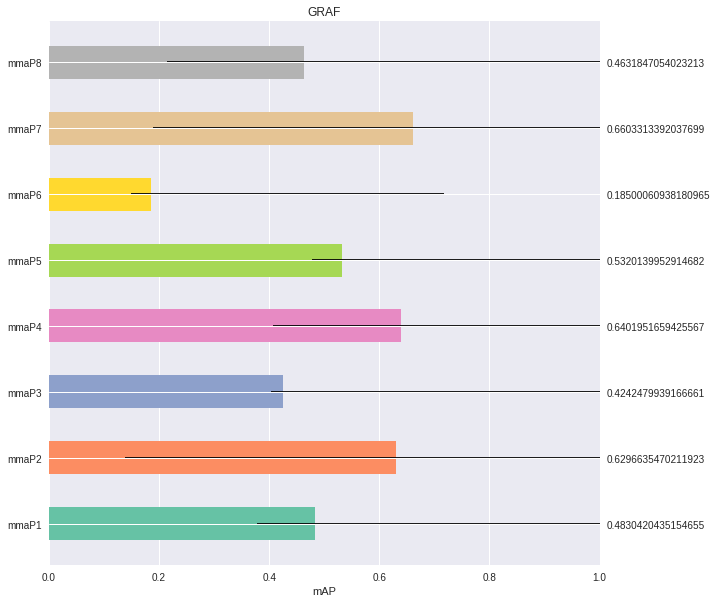

In [31]:
#import seaborn
#plt.style.use('seaborn')

fig, ax1 = plt.subplots(figsize=(10,10))
fig.subplots_adjust(left=0.115, right=0.88)

#ax1.set_style('seaborn')

ax1.barh(pos, scores,
         align='center',
         height=0.5,
         tick_label=names,
         xerr=np.array(err).T,
         color=seaborn.color_palette("Set2"))
plt.xlim([0, 1])
ax1.set_xlabel('mAP')

ax2 = ax1.twinx()
ax2.set_yticks(pos)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(scores)

ax1.set_title('GRAF')
fig.show()